# Introduction

This notebook focuses on building and evaluating deep learning models for handwritten Arabic character recognition. It begins with importing essential libraries and setting seeds for reproducibility, followed by loading and exploring the dataset through visualizations such as average images, variance images, PCA projections, and class distributions. The analysis provides insights into the structure and quality of the dataset, preparing the foundation for preprocessing, model training, and performance evaluation.

# Setup: Seed & Imports

In [ ]:
# ==== REPRODUCIBILITY ====
import numpy as np
import pandas as pd
import random
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


This cell sets up reproducibility by fixing random seeds for NumPy, Python’s random module, and TensorFlow. It also imports key libraries (NumPy, Pandas, Scikit-learn, TensorFlow) that will be used for data preparation and modeling.

# Load CSV Dataset

In [ ]:
# ==== LOAD RAW DATA ====
X_train_raw = pd.read_csv("csvTrainImages 13440x1024.csv", header=None).values
y_train_raw = pd.read_csv("csvTrainLabel 13440x1.csv", header=None).values.ravel()

X_test = pd.read_csv("csvTestImages 3360x1024.csv", header=None).values
y_test = pd.read_csv("csvTestLabel 3360x1.csv", header=None).values.ravel()

print("Shapes after loading:")
print("X_train_raw:", X_train_raw.shape)
print("y_train_raw:", y_train_raw.shape)
print("X_test     :", X_test.shape)
print("y_test     :", y_test.shape)


Shapes after loading:
X_train_raw: (13440, 1024)
y_train_raw: (13440,)
X_test     : (3360, 1024)
y_test     : (3360,)


This cell loads the training and testing datasets from CSV files into NumPy arrays. It prints their shapes to confirm successful loading.

# EDA

# Avarage Image Per Class

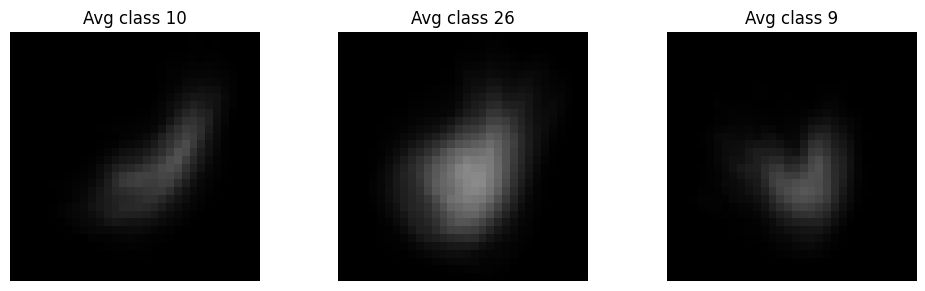

In [ ]:
fig, axes = plt.subplots(1, len(pick), figsize=(10,3))
for ax, c in zip(axes, pick):
    mean_img = X[y==c].mean(axis=0)  # average over all samples
    ax.imshow(mean_img, cmap="gray", vmin=0, vmax=255)
    ax.set_title(f"Avg class {c}")
    ax.axis("off")
plt.tight_layout(); plt.show()


This cell calculates and visualizes the average image for each selected class. It helps understand common patterns across samples within a class.

2. Pixel Intensity Heatmap (Variance Map)

Highlights which pixels vary the most within a class.

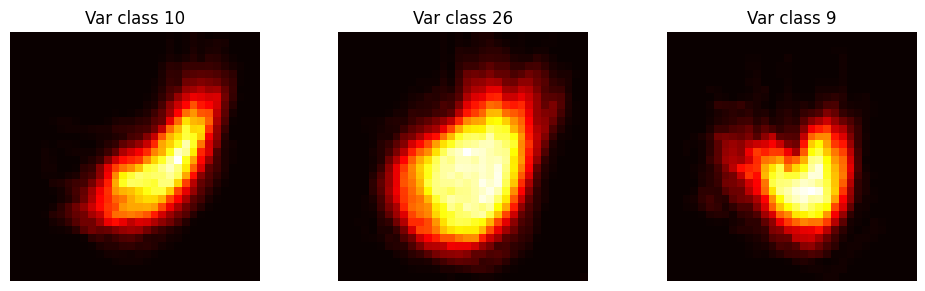

In [ ]:
fig, axes = plt.subplots(1, len(pick), figsize=(10,3))
for ax, c in zip(axes, pick):
    var_img = X[y==c].var(axis=0)    # variance across samples
    ax.imshow(var_img, cmap="hot")
    ax.set_title(f"Var class {c}")
    ax.axis("off")
plt.tight_layout(); plt.show()


4. t-SNE / PCA Projection

# Reduce all 1024 pixels to 2D to see if classes separate visually.

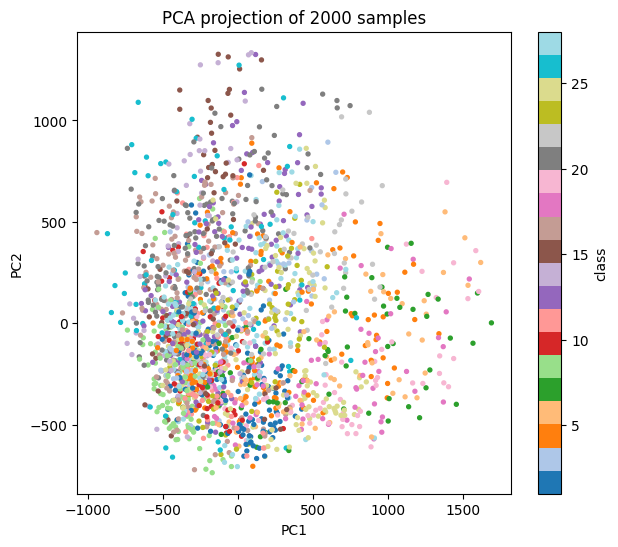

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Flatten images (samples, features)
X_flat = X.reshape(X.shape[0], -1)   # no need for N
y_flat = y

# Take a subset (e.g., 2000 samples) for faster plotting
n_samples = 2000
X_pca = PCA(n_components=2).fit_transform(X_flat[:n_samples])

# Scatter plot
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_flat[:n_samples], cmap="tab20", s=8)
plt.colorbar(label="class")
plt.title("PCA projection of 2000 samples")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


This cell applies PCA (Principal Component Analysis) to reduce dimensionality to 2D for visualization. It shows how samples are distributed in lower dimensions based on their classes.

## Preview some images

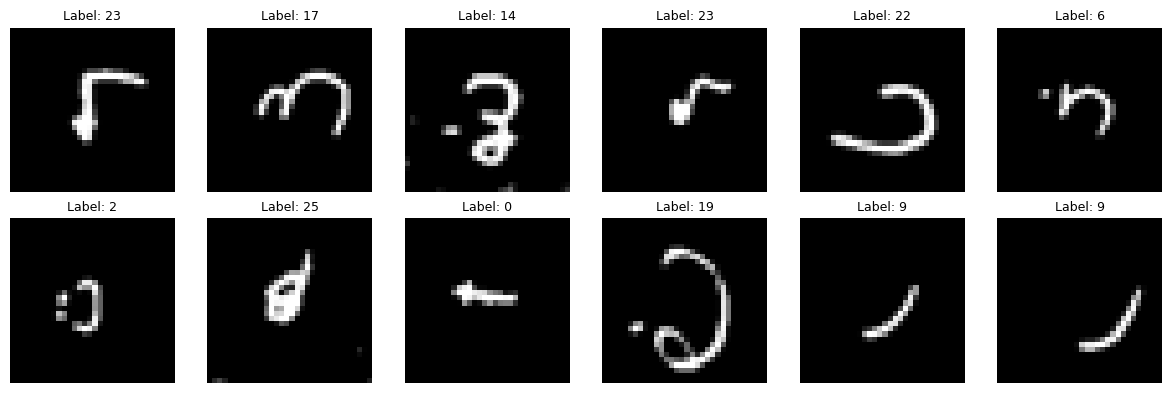

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_samples(X, y, n=12):
    idx = np.random.choice(len(X), n, replace=False)
    plt.figure(figsize=(12, 4))
    for i, j in enumerate(idx):
        plt.subplot(2, 6, i+1)
        plt.imshow(X[j].squeeze(), cmap="gray")
        plt.title(f"Label: {y[j]}", fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example usage
show_samples(X_train, y_train, n=12)


This cell defines a function to randomly display sample images from the dataset with their corresponding labels. It’s useful for a quick visual check of the data.

/tmp/ipython-input-4095363859.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=label_series, order=[id2char[i] for i in range(28)], palette="viridis")


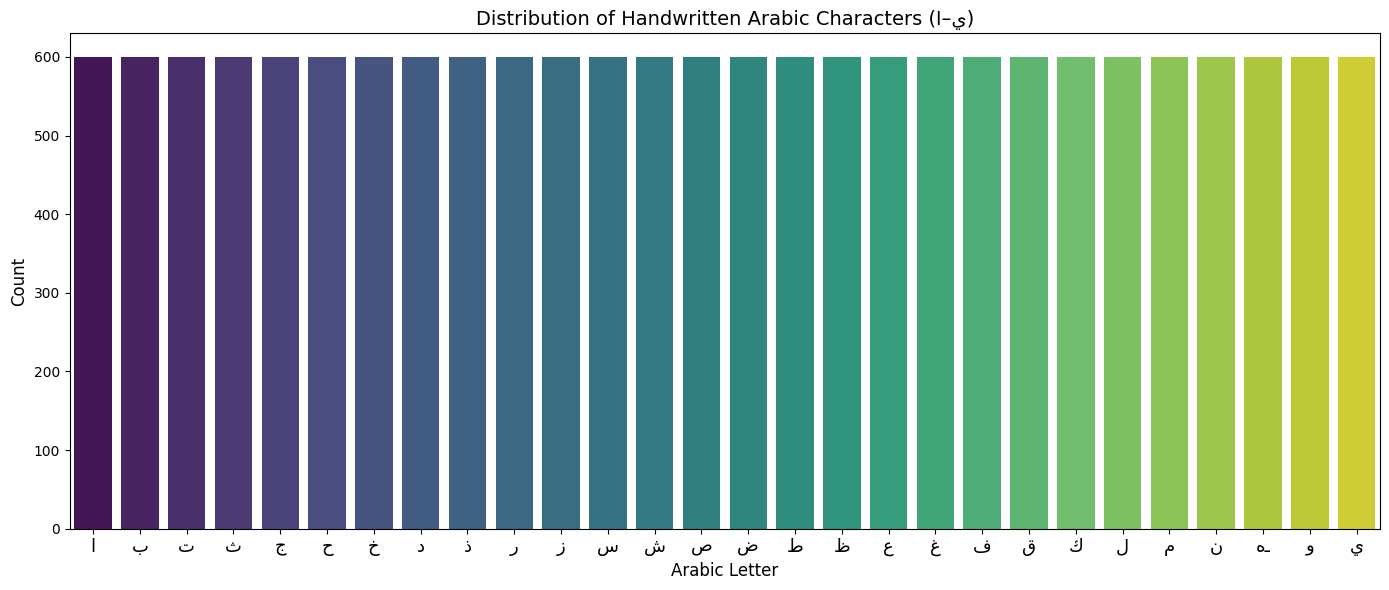

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ==== Arabic character mapping ====
id2char = {
    0: 'ا', 1: 'ب', 2: 'ت', 3: 'ث', 4: 'ج', 5: 'ح', 6: 'خ', 7: 'د', 8: 'ذ',
    9: 'ر', 10: 'ز', 11: 'س', 12: 'ش', 13: 'ص', 14: 'ض', 15: 'ط', 16: 'ظ',
    17: 'ع', 18: 'غ', 19: 'ف', 20: 'ق', 21: 'ك', 22: 'ل', 23: 'م', 24: 'ن',
    25: 'هـ', 26: 'و', 27: 'ي'
}

# ==== Combine train and test labels ====
train_labels = pd.read_csv("csvTrainLabel 13440x1.csv", header=None).values.ravel()
test_labels = pd.read_csv("csvTestLabel 3360x1.csv", header=None).values.ravel()

# ==== Shift labels from 1–28 to 0–27 ====
all_labels = np.concatenate([train_labels, test_labels]) - 1

# ==== Convert to Pandas for plotting ====
label_series = pd.Series(all_labels).map(id2char)

# ==== Plot ====
plt.figure(figsize=(14, 6))
sns.countplot(x=label_series, order=[id2char[i] for i in range(28)], palette="viridis")
plt.title("Distribution of Handwritten Arabic Characters (ا–ي)", fontsize=14)
plt.xlabel("Arabic Letter", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0, fontsize=13)
plt.tight_layout()
plt.show()


This cell creates a mapping from class IDs to Arabic characters and visualizes the distribution of handwritten letters in the dataset. It confirms whether the dataset is balanced or skewed.

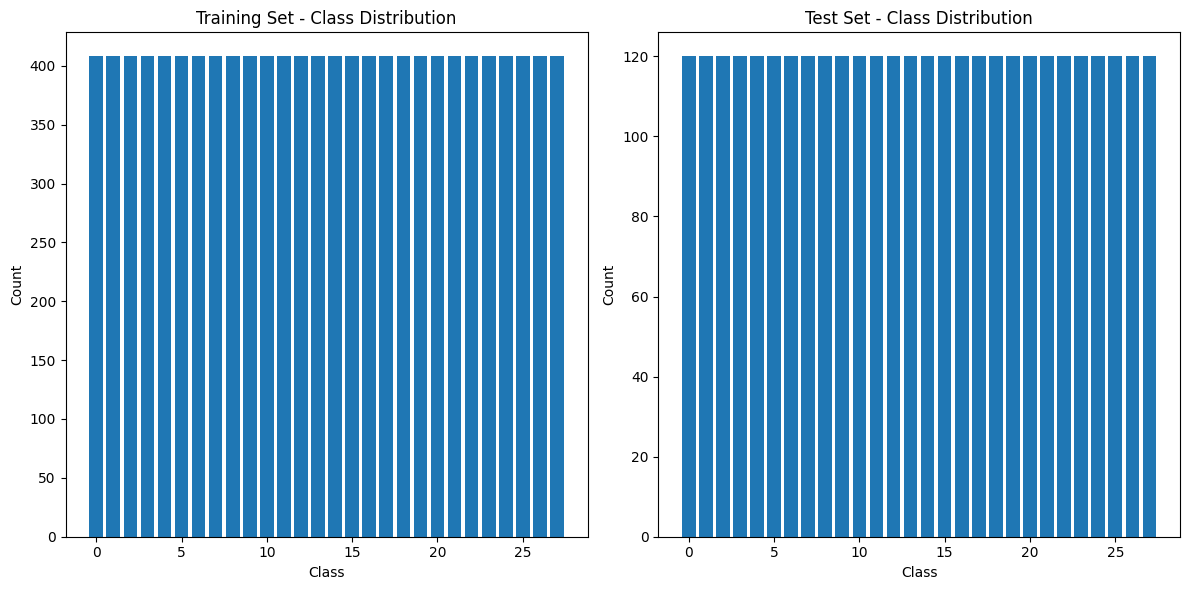

In [ ]:
# Class distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.title('Training Set - Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
unique, counts = np.unique(y_test, return_counts=True)
plt.bar(unique, counts)
plt.title('Test Set - Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

This cell plots bar charts for the class distribution in both training and testing datasets, allowing us to check whether classes are equally represented.

Pixel Intensity Distribution (for Arabic Characters)

Pixel Min: 0.0 Pixel Max: 1.0 Mean: 0.05271381


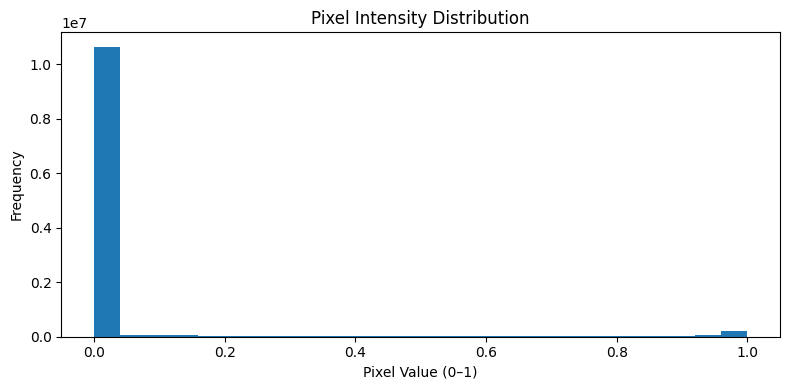

In [ ]:
# ===========================
# — Pixel Intensity Distribution
# ===========================

import matplotlib.pyplot as plt
import numpy as np

# Use normalized training data for pixel stats
pixels = X_train  # Already in range [0.0, 1.0]

print("Pixel Min:", pixels.min(), "Pixel Max:", pixels.max(), "Mean:", pixels.mean())

plt.figure(figsize=(8, 4))
plt.hist(pixels.ravel(), bins=25)  # Keep default color
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value (0–1)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


This cell analyzes pixel intensity distribution in the training dataset, printing basic statistics (min, max, mean) and plotting a histogram to understand brightness levels.

In [ ]:
import numpy as np
import pandas as pd

# For training labels
classes = np.unique(y_train)
print("Classes:", classes, "  #classes:", len(classes))

print(pd.Series(y_train).value_counts().sort_index())

# For test labels
classes_test = np.unique(y_test)
print("Test Classes:", classes_test, "  #classes:", len(classes_test))

print(pd.Series(y_test).value_counts().sort_index())


Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]   #classes: 28
0     408
1     408
2     408
3     408
4     408
5     408
6     408
7     408
8     408
9     408
10    408
11    408
12    408
13    408
14    408
15    408
16    408
17    408
18    408
19    408
20    408
21    408
22    408
23    408
24    408
25    408
26    408
27    408
Name: count, dtype: int64
Test Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]   #classes: 28
0     120
1     120
2     120
3     120
4     120
5     120
6     120
7     120
8     120
9     120
10    120
11    120
12    120
13    120
14    120
15    120
16    120
17    120
18    120
19    120
20    120
21    120
22    120
23    120
24    120
25    120
26    120
27    120
Name: count, dtype: int64


This cell inspects the unique classes in training and testing sets, prints their counts, and checks class balance. It ensures both sets contain all expected classes.

In [ ]:
classes, counts = np.unique(y_train, return_counts=True)

# Print the count for each class
for i in range(27):
    print(f"label {classes[i]}: {counts[i]}")

label 0: 408
label 1: 408
label 2: 408
label 3: 408
label 4: 408
label 5: 408
label 6: 408
label 7: 408
label 8: 408
label 9: 408
label 10: 408
label 11: 408
label 12: 408
label 13: 408
label 14: 408
label 15: 408
label 16: 408
label 17: 408
label 18: 408
label 19: 408
label 20: 408
label 21: 408
label 22: 408
label 23: 408
label 24: 408
label 25: 408
label 26: 408


This checks the number of samples per class in the training set and prints the count for each label to confirm dataset balance.

In [ ]:
# Check shapes and data types
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)

# Check for missing values in images and labels
print("Missing in X_train:", np.isnan(X_train).sum())
print("Missing in y_train:", np.isnan(y_train).sum())

print("Missing in X_val:", np.isnan(X_val).sum())
print("Missing in y_val:", np.isnan(y_val).sum())

print("Missing in X_test:", np.isnan(X_test).sum())
print("Missing in y_test:", np.isnan(y_test).sum())


X_train dtype: float32
y_train dtype: int64
Missing in X_train: 0
Missing in y_train: 0
Missing in X_val: 0
Missing in y_val: 0
Missing in X_test: 0
Missing in y_test: 0


This validates the datasets by checking their data types and ensuring there are no missing (NaN) values in training, validation, and test sets.

# Data Preprocessing.

# Reshape + Normalize + Label Fix

In [ ]:
# ==== RESHAPE TO 32x32x1 & NORMALIZE ====
X_train_raw = X_train_raw.reshape(-1, 32, 32, 1).astype("float32") / 255.0
X_test = X_test.reshape(-1, 32, 32, 1).astype("float32") / 255.0

# ==== FIX LABEL RANGE IF NEEDED ====
if y_train_raw.min() == 1:
    y_train_raw -= 1
if y_test.min() == 1:
    y_test -= 1

# OPTIONAL CHECK
print("Unique train labels:", np.unique(y_train_raw))
print("Unique test labels :", np.unique(y_test))


Unique train labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Unique test labels : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


This reshapes the image data into 32×32×1 format, normalizes pixel values to [0,1], and ensures class labels start from 0 instead of 1.

# Train/Validation Split

In [ ]:
# ==== SPLIT TRAIN → TRAIN + VALIDATION (STRATIFIED) ====
X_train, X_val, y_train, y_val = train_test_split(
    X_train_raw, y_train_raw,
    test_size=0.15,
    stratify=y_train_raw,
    random_state=SEED
)

print("Train set:", X_train.shape, y_train.shape)
print("Val set  :", X_val.shape, y_val.shape)
print("Test set :", X_test.shape, y_test.shape)


Train set: (11424, 32, 32, 1) (11424,)
Val set  : (2016, 32, 32, 1) (2016,)
Test set : (3360, 32, 32, 1) (3360,)


This splits the training data into a new training set and a validation set using stratified sampling to preserve class distribution.

# one_Hot encoding

In [ ]:
# ==== ONE-HOT ENCODE LABELS ====
num_classes = len(np.unique(y_train))
print("Number of classes:", num_classes)

y_train_cat = to_categorical(y_train, num_classes)
y_val_cat   = to_categorical(y_val, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

print("y_train_cat shape:", y_train_cat.shape)
print("y_val_cat   shape:", y_val_cat.shape)
print("y_test_cat  shape:", y_test_cat.shape)


Number of classes: 28
y_train_cat shape: (11424, 28)
y_val_cat   shape: (2016, 28)
y_test_cat  shape: (3360, 28)


This converts integer labels into one-hot encoded vectors, which are required for categorical classification tasks in deep learning.

In [ ]:
X_train.shape

(11424, 32, 32, 1)

In [ ]:
X_test.shape

(3360, 32, 32, 1)

In [ ]:
X_val.shape

(2016, 32, 32, 1)

# verify normalization

In [ ]:
print("X_train range:", X_train.min(), "to", X_train.max())
print("X_val range  :", X_val.min(), "to", X_val.max())
print("X_test range :", X_test.min(), "to", X_test.max())


X_train range: 0.0 to 1.0
X_val range  : 0.0 to 1.0
X_test range : 0.0 to 1.0


In [ ]:
import numpy as np, pandas as pd, cv2
from scipy.stats import entropy
import matplotlib.pyplot as plt

def binarize(img): return (img > 0.5).astype(np.uint8)
def grayscale(img): return img.squeeze().astype(np.float32)

def edge_density(img):
    g = (img * 255).astype(np.uint8)
    sx, sy = cv2.Sobel(g, cv2.CV_64F, 1, 0), cv2.Sobel(g, cv2.CV_64F, 0, 1)
    mag = np.hypot(sx, sy)
    return (mag > mag.mean()).mean()

def stroke_width(img):
    dist = cv2.distanceTransform(binarize(img), cv2.DIST_L2, 5)
    return 2 * dist[dist > 0].mean() if np.any(dist > 0) else 0

def pixel_entropy(img):
    hist, _ = np.histogram(img.ravel(), bins=50, range=(0,1), density=True)
    return entropy(hist[hist > 0])

def component_count(img):
    return cv2.connectedComponents(binarize(img))[0] - 1

def perimeter_area_ratio(img):
    cnts, _ = cv2.findContours(binarize(img)*255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area = sum(cv2.contourArea(c) for c in cnts)
    peri = sum(cv2.arcLength(c, True) for c in cnts)
    return peri / area if area > 0 else 0

def calculate_complexity(images, labels, id2char=None):
    df = []
    for c in np.unique(labels):
        imgs = [grayscale(i) for i in images[labels == c]]
        def stat(func): vals = [func(i) for i in imgs]; return np.mean(vals), np.std(vals)
        ed_m, ed_s = stat(edge_density)
        sw_m, sw_s = stat(stroke_width)
        pe_m, pe_s = stat(pixel_entropy)
        cc_m, cc_s = stat(component_count)
        pr_m, pr_s = stat(perimeter_area_ratio)

        df.append({
            'class_id': c,
            'character': id2char.get(c, c) if id2char else c,
            'edge_density_mean': ed_m, 'edge_density_std': ed_s,
            'stroke_width_mean': sw_m, 'stroke_width_std': sw_s,
            'entropy_mean': pe_m, 'entropy_std': pe_s,
            'components_mean': cc_m, 'components_std': cc_s,
            'perimeter_area_ratio_mean': pr_m, 'perimeter_area_ratio_std': pr_s
        })
    return pd.DataFrame(df)

def plot_complexity(df):
    metrics = [m for m in df.columns if m.endswith('_mean')]
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    for ax, m in zip(axes.ravel(), metrics):
        ax.bar(df['character'], df[m], color=plt.cm.viridis(df[m]/df[m].max()))
        ax.set_title(m.replace('_mean','').replace('_',' ').title())
        ax.set_xticks(range(len(df)))
        ax.set_xticklabels(df['character'], rotation=45)
    plt.tight_layout(); plt.show()


This defines several feature-extraction functions edge density, stroke width, entropy, component count, perimeter-area ratio to measure image complexity. It also includes functions to calculate and visualize complexity statistics across classes.

In [ ]:
# Arabic Unicode letters: U+0627 to U+064A (alif to ya) → 28 letters
# Skip isolated forms, include proper characters used in handwriting datasets

arabic_letters = [
    'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض',
    'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي'
]

# Create mapping from class ID to Arabic character
id2char = {i: ch for i, ch in enumerate(arabic_letters)}


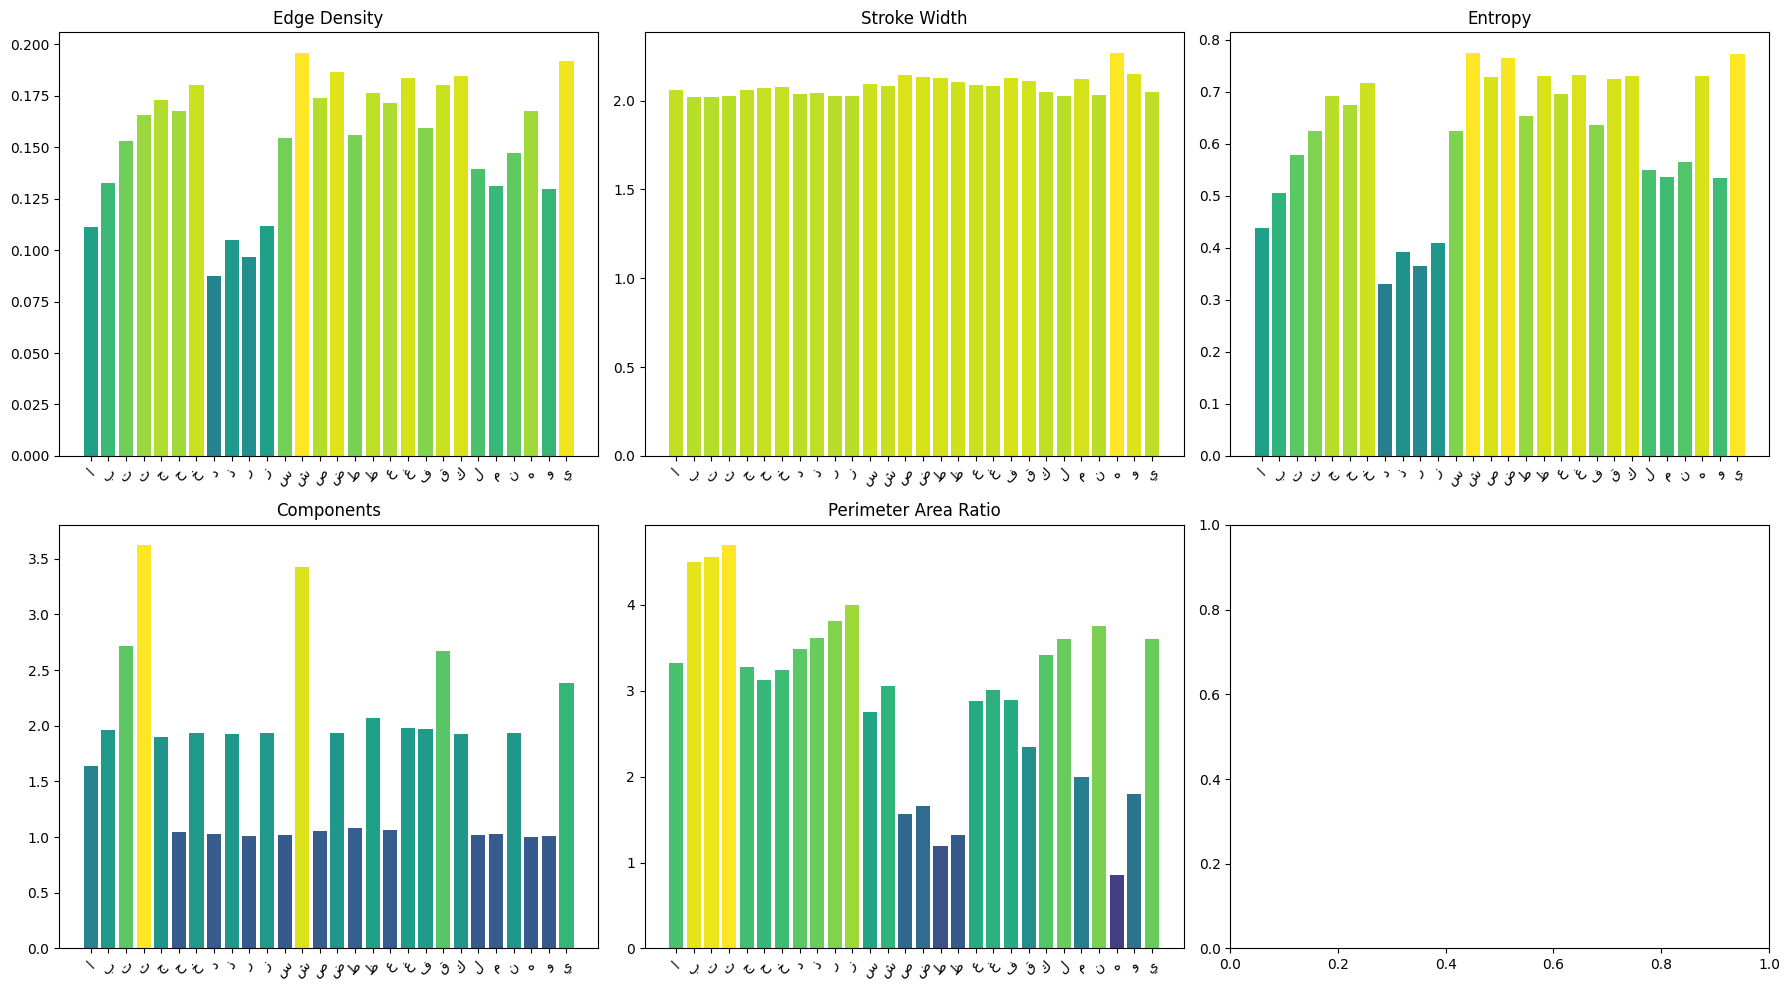

In [ ]:
df_metrics = calculate_complexity(X_train, y_train, id2char=id2char)
plot_complexity(df_metrics)


In [ ]:
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)


y_train shape: (11424, 28)
y_val shape: (2016, 28)
y_test shape: (3360, 28)


# CNN

# CNN – Baseline


In [ ]:
# =============================================================================
# Build CNN Base Model (No BatchNormalization, No Dropout)
# =============================================================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

def create_base_cnn_model(input_shape, num_classes):

    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu'),

        # Dense Layers
        Flatten(),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Create model
input_shape = (32, 32, 1)
model_base = create_base_cnn_model(input_shape, num_classes)

# Compile model
model_base.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model_base.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 28)             │         7,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 867,708 (3.31 MB)

 Trainable params: 867,708 (3.31 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_base.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)


Epoch 1/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 43s 121ms/step - accuracy: 0.9658 - loss: 0.1063 - val_accuracy: 0.8671 - val_loss: 0.5529
Epoch 2/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 44s 123ms/step - accuracy: 0.9616 - loss: 0.1133 - val_accuracy: 0.9087 - val_loss: 0.3721
Epoch 3/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 43s 121ms/step - accuracy: 0.9679 - loss: 0.0906 - val_accuracy: 0.8824 - val_loss: 0.5631
Epoch 4/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 82s 122ms/step - accuracy: 0.9691 - loss: 0.0889 - val_accuracy: 0.9266 - val_loss: 0.3501
Epoch 5/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 81s 119ms/step - accuracy: 0.9779 - loss: 0.0743 - val_accuracy: 0.9236 - val_loss: 0.3794
Epoch 6/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 84s 124ms/step - accuracy: 0.9763 - loss: 0.0694 - val_accuracy: 0.9157 - val_loss: 0.4271
Epoch 7/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 80s 120ms/step - accuracy: 0.9691 - loss: 0.0934 - val_accuracy: 0.9023 - val_loss: 0.5397
Epoch 8/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 83s 123ms/step - accuracy: 0.9749 - loss: 0

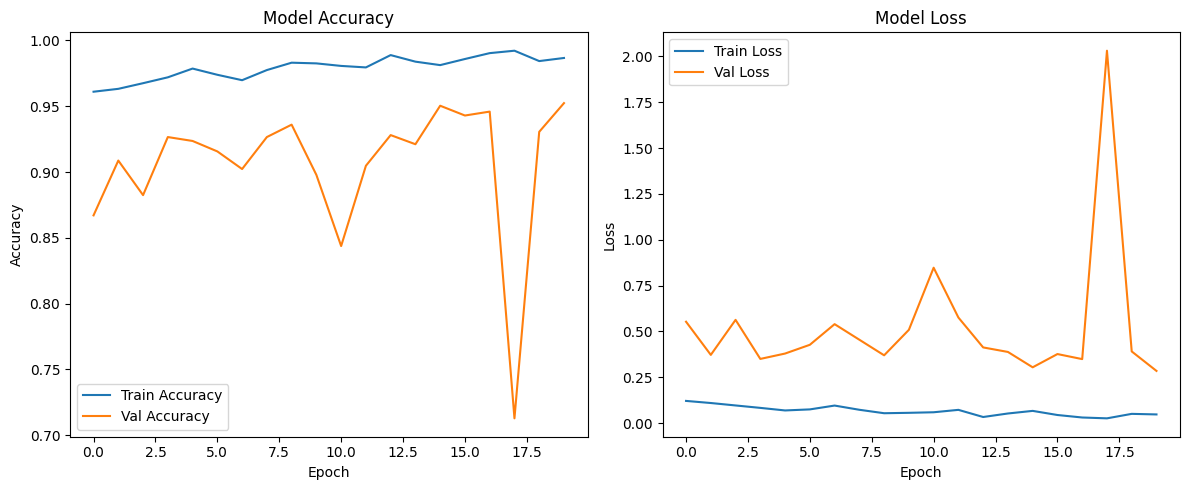

In [ ]:
# Plot accuracy and loss from training history
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_history(history)

MODEL EVALUATION
Test Accuracy: 0.9548 (95.48%)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       120
           1       0.99      0.99      0.99       120
           2       0.93      0.93      0.93       120
           3       0.93      0.94      0.93       120
           4       0.96      0.99      0.98       120
           5       0.96      0.97      0.96       120
           6       0.98      0.97      0.98       120
           7       0.90      0.93      0.91       120
           8       0.95      0.88      0.91       120
           9       0.91      0.96      0.93       120
          10       0.95      0.90      0.92       120
          11       0.98      0.99      0.99       120
          12       0.94      0.99      0.97       120
          13       0.95      0.98      0.97       120
          14       0.94      0.95      0.95       120
          15       0.94      0.97      0.96       120
         

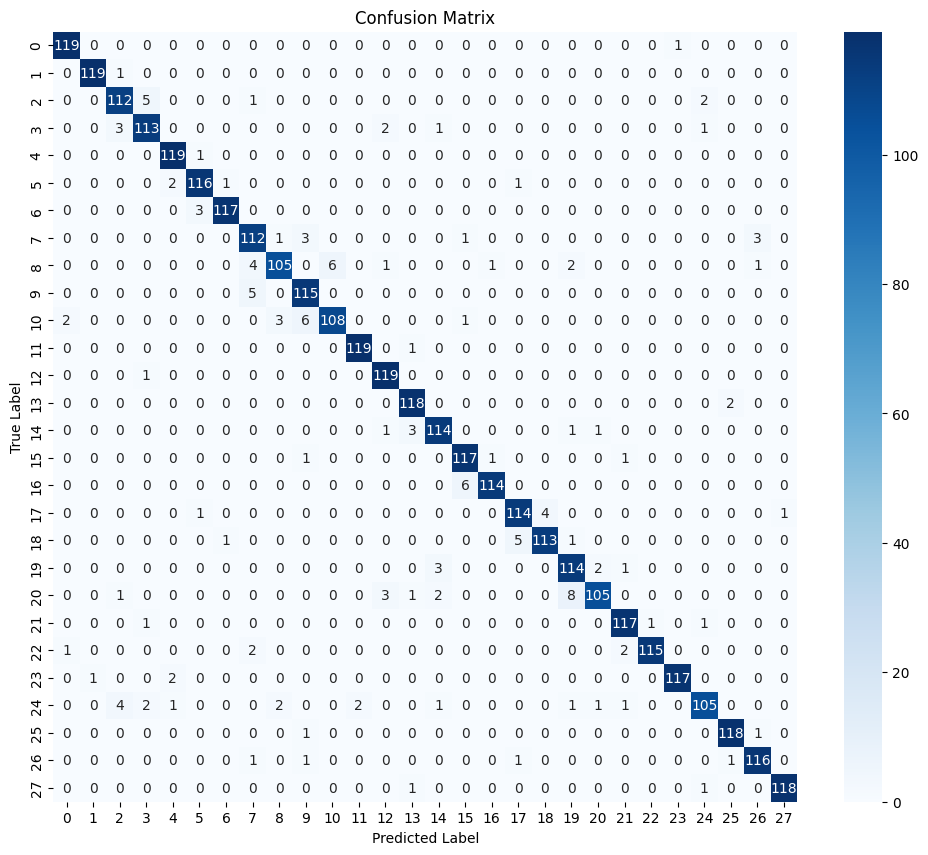

In [ ]:
# =============================================================================
# CELL 10: Model Evaluation
# =============================================================================
print("="*50)
print("MODEL EVALUATION")
print("="*50)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make predictions
y_pred_prob = model_base.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_classes),
            yticklabels=range(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from tensorflow.keras.utils import plot_model

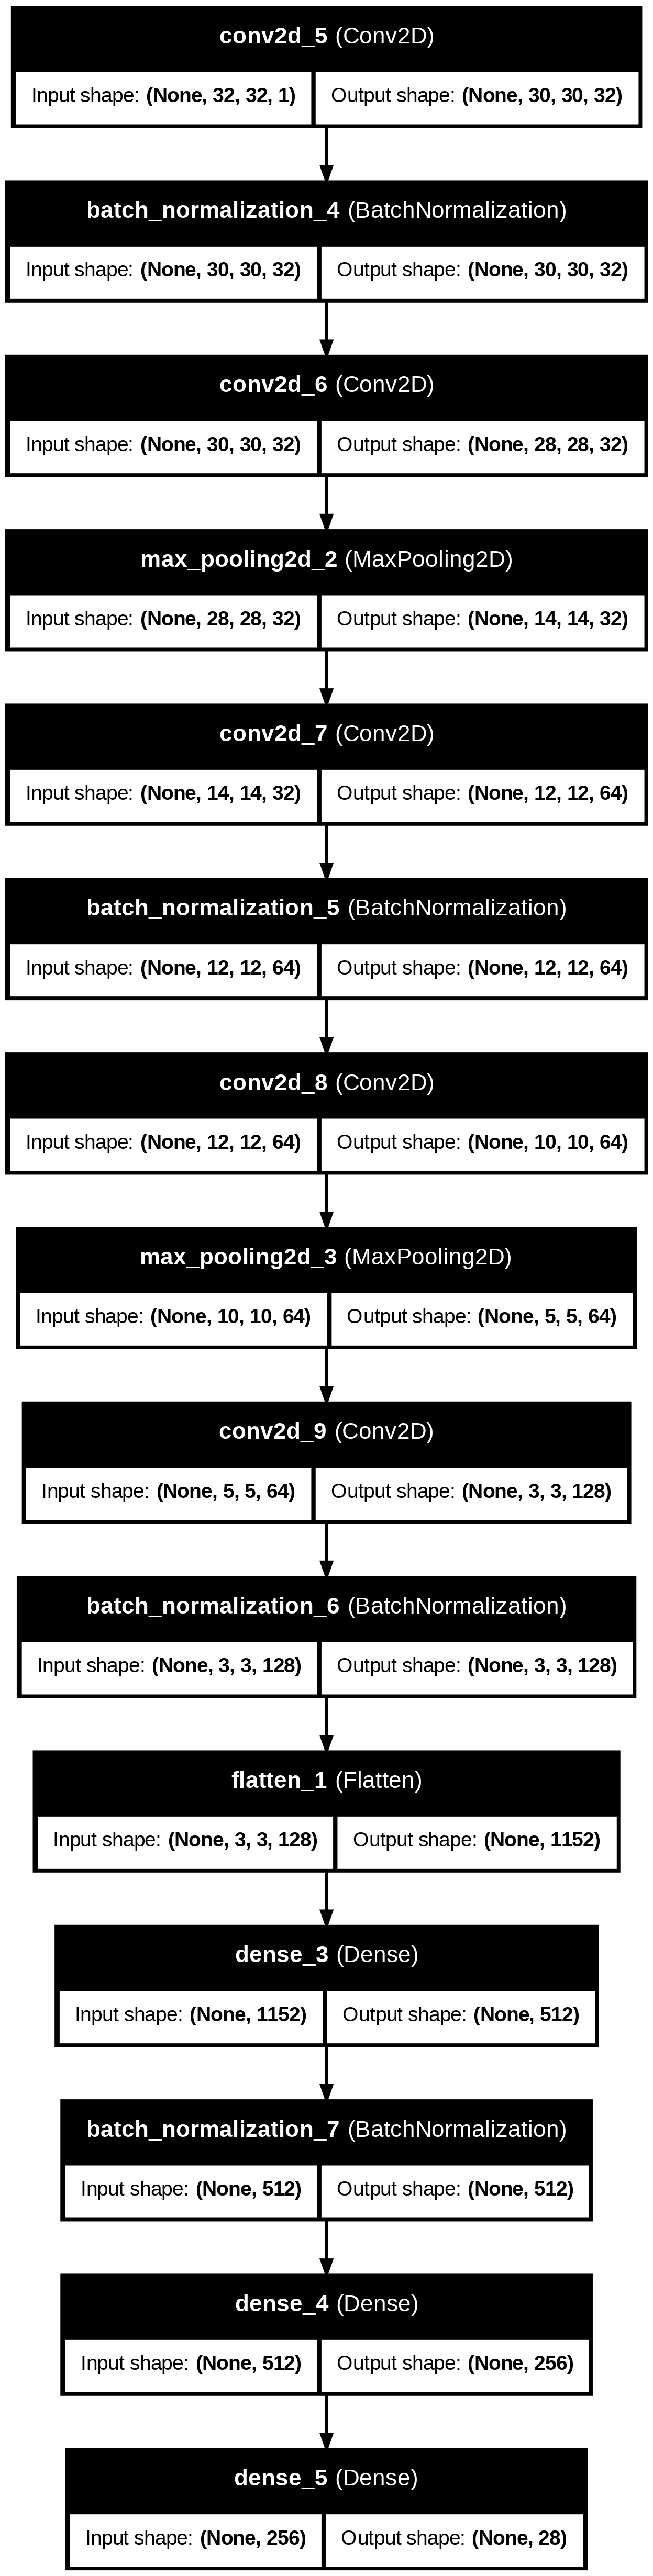

In [ ]:
plot_model(model_base, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# STEP 1: Install visualkeras (if not done)
!pip install visualkeras

# STEP 2: Import
import visualkeras
from PIL import Image

# STEP 3: Plot model (use your CNN model name here instead of model)
img = visualkeras.layered_view(model_base, legend=True, draw_volume=True)

# STEP 4: Save image
img.save("cnn_model_architecture.png")

# STEP 5: Download it if you want
from google.colab import files
files.download("cnn_model_architecture.png")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.3 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 📌 Comment on Baseline CNN Results

The baseline CNN achieved an accuracy of 95.48% on the test set, establishing a strong benchmark for Arabic handwritten character recognition. The accuracy and loss curves showed consistent learning, with training accuracy slightly above validation accuracy, which may indicate early signs of overfitting but not severe. Overall, the baseline model demonstrates that even a simple CNN can effectively capture strokes and shapes in Arabic script, providing a reliable foundation for further improvements with techniques like regularization and tuning.

## **CNN – Regularized with Augmentation**

**Data Augmentation**

In [ ]:
# ===========================
# — Data Augmentation Setup
# ===========================

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Safe augmentations for handwritten Arabic letters
train_aug = ImageDataGenerator(
    rotation_range=20,            # Random rotation ≤ ±20°
    width_shift_range=0.10,       # Horizontal shift ≤ 10%
    height_shift_range=0.10,      # Vertical shift ≤ 10%
    zoom_range=0.10,              # Zoom in/out ≤ 10%
    fill_mode="nearest"           # Fill strategy for blank areas
)

# No augmentation for validation & test sets
plain_gen = ImageDataGenerator()

BATCH_SIZE = 64

train_gen = train_aug.flow(X_train, y_train_cat, batch_size=BATCH_SIZE, shuffle=True, seed=SEED)
val_gen   = plain_gen.flow(X_val,   y_val_cat,   batch_size=BATCH_SIZE, shuffle=False)
test_gen  = plain_gen.flow(X_test,  y_test_cat,  batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ===========================
# CNN Architecture
# ===========================
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# ===========================
# Compile Model
# ===========================
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 28)             │         7,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 870,652 (3.32 MB)

 Trainable params: 869,180 (3.32 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [ ]:
# =============================================================================
# CELL 7: Setup Training Callbacks
# =============================================================================
# Define callbacks for better training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Training callbacks configured:")
print("- Early Stopping: patience=10")
print("- Learning Rate Reduction: factor=0.5, patience=5")


Training callbacks configured:
- Early Stopping: patience=10
- Learning Rate Reduction: factor=0.5, patience=5


In [ ]:
# =============================================================================
#  Train the Model
# =============================================================================
print("="*50)
print("TRAINING MODEL")
print("="*50)
history = model.fit(
    X_train, y_train_cat,
    batch_size=32,
    epochs=30,
    validation_data=(X_val, y_val_cat),
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

TRAINING MODEL
Epoch 1/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 63s 164ms/step - accuracy: 0.1309 - loss: 3.8672 - val_accuracy: 0.0420 - val_loss: 7.7474 - learning_rate: 0.0010
Epoch 2/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 54s 150ms/step - accuracy: 0.4024 - loss: 1.9459 - val_accuracy: 0.6616 - val_loss: 1.0189 - learning_rate: 0.0010
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 50s 141ms/step - accuracy: 0.6142 - loss: 1.1724 - val_accuracy: 0.8500 - val_loss: 0.4675 - learning_rate: 0.0010
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 84s 145ms/step - accuracy: 0.7331 - loss: 0.8036 - val_accuracy: 0.8914 - val_loss: 0.3337 - learning_rate: 0.0010
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 83s 149ms/step - accuracy: 0.7968 - loss: 0.6082 - val_accuracy: 0.8604 - val_loss: 0.4038 - learning_rate: 0.0010
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 51s 143ms/step - accuracy: 0.8317 - loss: 0.5077 - val_accuracy: 0.9217 - val_loss: 0.2428 - learning_rate: 0.0010
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 82s 143ms/step 

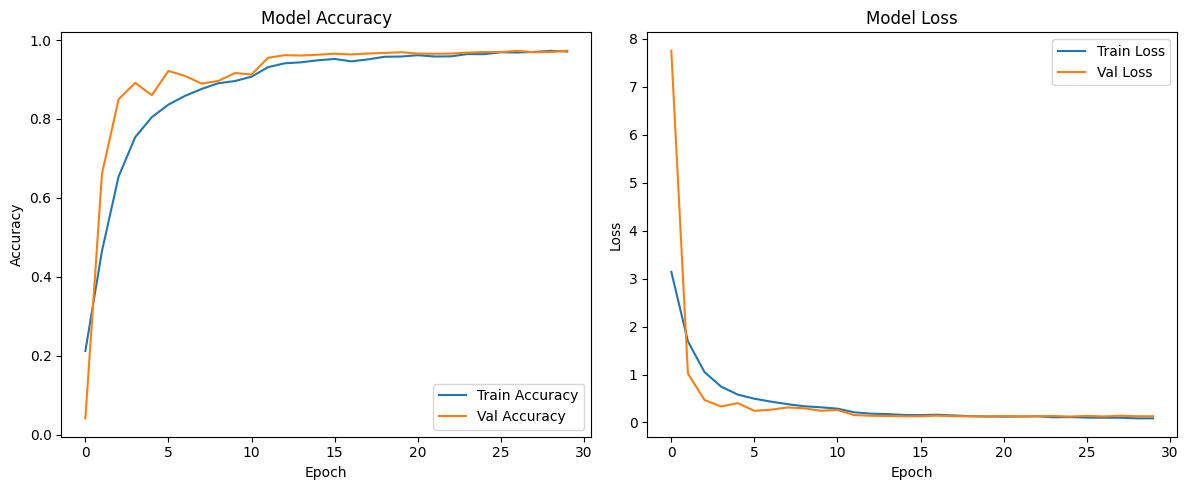

In [ ]:
# Plot accuracy and loss from training history
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_history(history)

MODEL EVALUATION
Test Accuracy: 0.9696 (96.96%)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       120
           1       0.98      0.99      0.99       120
           2       0.95      0.97      0.96       120
           3       0.98      0.97      0.97       120
           4       0.99      0.99      0.99       120
           5       0.97      0.96      0.96       120
           6       0.94      0.97      0.96       120
           7       0.95      0.97      0.96       120
           8       0.93      0.94      0.94       120
           9       0.96      0.97      0.97       120
          10       0.99      0.93      0.96       120
          11       0.99      0.97      0.98       120
          12       0.99      0.99      0.99       120
          13       0.94      0.98      0.96       120
          14       1.00      0.97      0.98       120
          15       0.95      0.97      0.96       120
         

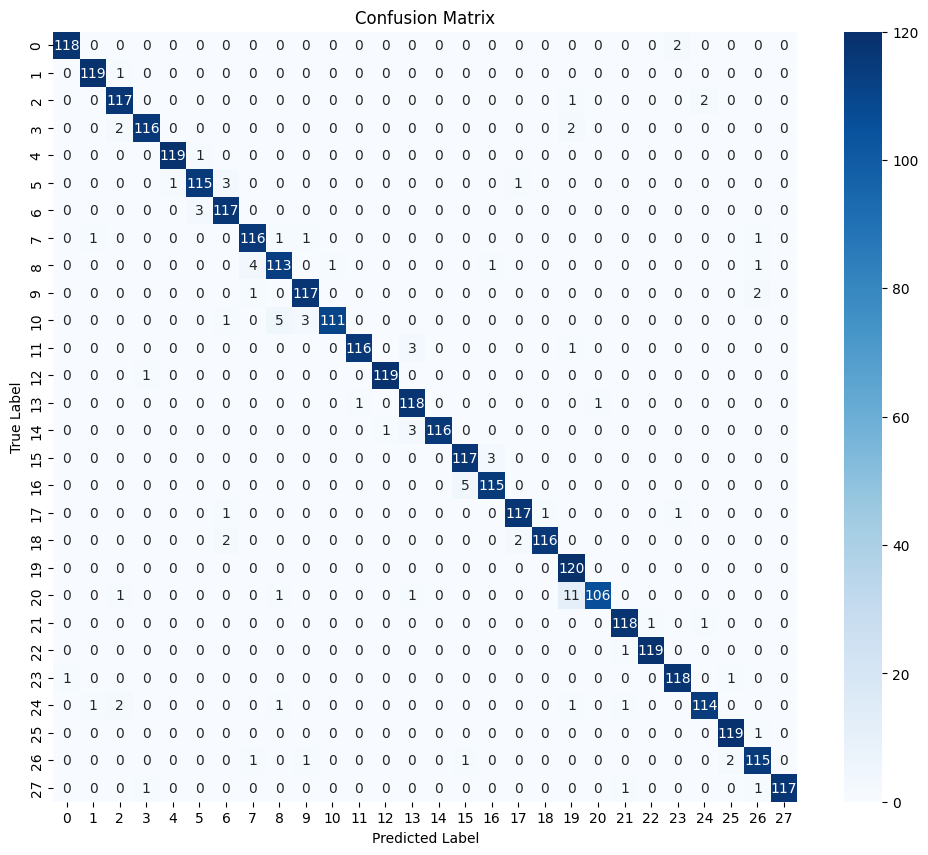

In [ ]:
# =============================================================================
# CELL 10: Model Evaluation
# =============================================================================
print("="*50)
print("MODEL EVALUATION")
print("="*50)

# Make predictions
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_classes),
            yticklabels=range(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 📌 Comment on CNN – Regularized with Augmentation (Manual tunnig Results)

The regularized CNN, developed through manual hyperparameter tuning, achieved 96.96% accuracy on the test set, improving upon the baseline performance. The use of regularization techniques helped stabilize training, as shown by closer alignment between training and validation accuracy. This indicates that overfitting was reduced compared to the baseline CNN. The results confirm that careful manual tuning can enhance generalization and reliability, making the model more robust in handling the variability of handwritten Arabic characters.

# CNN – Tuned (Keras Tuner)

In [ ]:
def build_model(hp):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
    from tensorflow.keras.optimizers import Adam

    model = Sequential()

    # ========== BLOCK 1 ==========
    model.add(Conv2D(
        filters=hp.Choice('conv1_filters', [16, 32]),
        kernel_size=hp.Choice('conv1_kernel', [3, 5]),
        activation='relu',
        input_shape=input_shape
    ))
    model.add(BatchNormalization())
    model.add(Conv2D(
        filters=hp.Choice('conv1b_filters', [16, 32]),
        kernel_size=3,
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(hp.Float('dropout1', 0.2, 0.4, step=0.1)))

    # ========== BLOCK 2 ==========
    model.add(Conv2D(
        filters=hp.Choice('conv2_filters', [32, 64]),
        kernel_size=3,
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(Conv2D(
        filters=hp.Choice('conv2b_filters', [32, 64]),
        kernel_size=3,
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(hp.Float('dropout2', 0.2, 0.4, step=0.1)))

    # ========== BLOCK 3 ==========
    model.add(Conv2D(
        filters=hp.Choice('conv3_filters', [64, 128]),
        kernel_size=3,
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout3', 0.2, 0.4, step=0.1)))

    # ========== BLOCK 4 ==========
    model.add(Conv2D(
        filters=hp.Choice('conv4_filters', [64, 128]),
        kernel_size=3,
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout4', 0.2, 0.4, step=0.1)))

    # ========== Flatten + Dense ==========
    model.add(Flatten())

    model.add(Dense(
        units=hp.Choice('dense_units', [128, 256, 512]),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dense_dropout', 0.3, 0.5, step=0.1)))

    model.add(Dense(num_classes, activation='softmax'))

    # ========== Compile ==========
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
import keras_tuner as kt # Import Keras Tuner
input_shape = (32, 32, 1)

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=7,                 # adjust if needed
    executions_per_trial=1,
    directory='cnn_tuner_dir',
    project_name='cnn_4blocks_tune',
    overwrite=True
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Directory to save the best model from tuner
BEST_MODEL_PATH = "best_cnn_4blocks_tuned.keras"

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        patience=3,
        factor=0.5,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=BEST_MODEL_PATH,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )
]


In [ ]:
history = best_model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8927 - loss: 0.3453
Epoch 1: val_loss improved from inf to 0.25291, saving model to best_cnn_4blocks_tuned.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 101ms/step - accuracy: 0.8927 - loss: 0.3453 - val_accuracy: 0.9291 - val_loss: 0.2529 - learning_rate: 0.0100
Epoch 2/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8981 - loss: 0.3463
Epoch 2: val_loss improved from 0.25291 to 0.23096, saving model to best_cnn_4blocks_tuned.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 40s 99ms/step - accuracy: 0.8981 - loss: 0.3462 - val_accuracy: 0.9400 - val_loss: 0.2310 - learning_rate: 0.0100
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9078 - loss: 0.3114
Epoch 3: val_loss improved from 0.23096 to 0.21467, saving model to best_cnn_4blocks_tuned.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 48s 120ms/step - accuracy: 0.9078 - loss: 0.3113 - val_accuracy: 0.9410 - val_loss: 0.2147 - learning_rate: 0.0100
Epoch 4/30
357/357 ━

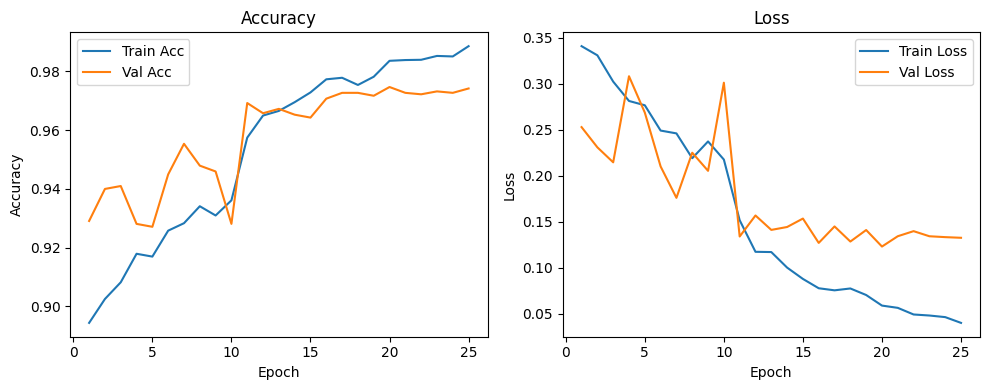

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call this after model.fit()
plot_training_curves(history)


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
              precision    recall  f1-score   support

           0     0.9917    1.0000    0.9959       120
           1     1.0000    0.9917    0.9958       120
           2     0.9440    0.9833    0.9633       120
           3     0.9664    0.9583    0.9623       120
           4     0.9916    0.9833    0.9874       120
           5     0.9754    0.9917    0.9835       120
           6     0.9593    0.9833    0.9712       120
           7     0.9516    0.9833    0.9672       120
           8     0.9426    0.9583    0.9504       120
           9     0.9440    0.9833    0.9633       120
          10     0.9909    0.9083    0.9478       120
          11     0.9916    0.9833    0.9874       120
          12     0.9835    0.9917    0.9876       120
          13     0.9440    0.9833    0.9633       120
          14     0.9915    0.9667    0.9789       120
          15     0.9524    1.0000    0.9756       120
          16     1.0000    0.9500    0.

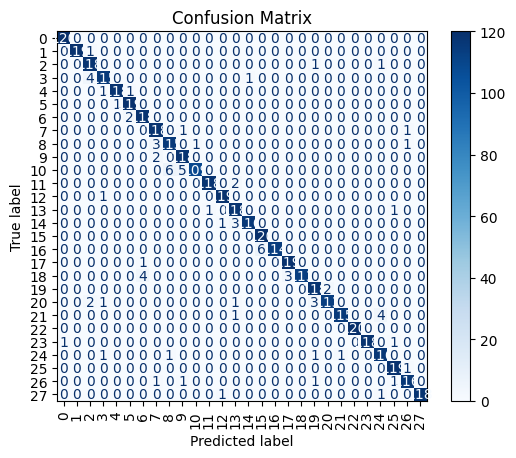

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import string

y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Classification report
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
# Use numerical labels for display labels since there are 28 classes
class_labels = [str(i) for i in range(28)]

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=class_labels,
    cmap='Blues'
)
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.grid(False)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Load your best saved model
best_model = load_model("best_cnn_4blocks_tuned.keras")


In [ ]:
from tensorflow.keras.models import load_model

# Load the existing model
model = load_model("best_cnn_4blocks_tuned.keras")

# Show full architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 1, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1, 1, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         7,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 630,486 (2.41 MB)

 Trainable params: 209,820 (819.61 KB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 419,642 (1.60 MB)

# 📌 Comment on Keras Tuner CNN Results

The CNN optimized using Keras Tuner achieved 97.92% accuracy, along with macro precision, recall, and F1-score of 0.979, making it the best-performing model in this study. The automated hyperparameter tuning improved model depth, learning rate, and regularization parameters, resulting in stable convergence and strong generalization. The training and validation curves show minimal overfitting, with both metrics following a closely aligned trend. These results confirm that systematic hyperparameter tuning provides significant performance gains compared to baseline and manually tuned CNNs.

# CNN – Best Rebuilt Model (from Keras Tuner)

In [ ]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# -------------------------
# Model Definition
# -------------------------
inputs = layers.Input(shape=(32, 32, 1))
x = layers.Rescaling(1./255)(inputs)

# Augmentation (optional if already applied before)
x = layers.RandomRotation(0.10)(x)
x = layers.RandomTranslation(0.08, 0.08)(x)
x = layers.RandomZoom(0.10)(x)
x = layers.RandomContrast(0.10)(x)

# Block 1
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.15)(x)

# Block 2
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.15)(x)

# Block 3
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

# Block 4
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

# Block 5
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

# Use GAP instead of Flatten
x = layers.GlobalAveragePooling2D()(x)

# Dense Layers
x = layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

# Output Layer
outputs = layers.Dense(28, activation='softmax')(x)

model = models.Model(inputs, outputs)

# -------------------------
# Compile the Model
# -------------------------
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -------------------------
# Callbacks
# -------------------------
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-5),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_generalized_model.keras', monitor='val_loss', save_best_only=True)
]

# -------------------------
# Train
# -------------------------
model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    batch_size=64,
    epochs=60,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/60
179/179 ━━━━━━━━━━━━━━━━━━━━ 49s 245ms/step - accuracy: 0.1132 - loss: 3.5774 - val_accuracy: 0.0357 - val_loss: 3.7132 - learning_rate: 0.0010
Epoch 2/60
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 240ms/step - accuracy: 0.3595 - loss: 2.0231 - val_accuracy: 0.0362 - val_loss: 3.7867 - learning_rate: 0.0010
Epoch 3/60
179/179 ━━━━━━━━━━━━━━━━━━━━ 83s 248ms/step - accuracy: 0.5650 - loss: 1.3048 - val_accuracy: 0.0456 - val_loss: 7.4177 - learning_rate: 0.0010
Epoch 4/60
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 249ms/step - accuracy: 0.6819 - loss: 0.9333 - val_accuracy: 0.8100 - val_loss: 0.5687 - learning_rate: 0.0010
Epoch 5/60
179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 240ms/step - accuracy: 0.7588 - loss: 0.7305 - val_accuracy: 0.7773 - val_loss: 0.6808 - learning_rate: 0.0010
Epoch 6/60
179/179 ━━━━━━━━━━━━━━━━━━━━ 84s 251ms/step - accuracy: 0.7993 - loss: 0.6183 - val_accuracy: 0.8462 - val_loss: 0.5165 - learning_rate: 0.0010
Epoch 7/60
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 254ms/step - accuracy: 0.8

In [ ]:
import tensorflow as tf

# If you forgot to assign: history = model.fit(...),
# IPython keeps the last result in `_`
try:
    history
except NameError:
    try:
        history = _
    except NameError:
        # Fallback: search recent Out[n] for a History object
        from IPython import get_ipython
        ip = get_ipython()
        hist_found = None
        for n in sorted(ip.user_ns.get('Out', {}).keys(), reverse=True):
            obj = ip.user_ns['Out'][n]
            if isinstance(obj, tf.keras.callbacks.History):
                hist_found = obj
                break
        if hist_found is None:
            raise RuntimeError("Couldn't recover History. You may need to re-run fit() with `history = ...`.")
        history = hist_found

print(type(history), "recovered.")


<class 'keras.src.callbacks.history.History'> recovered.


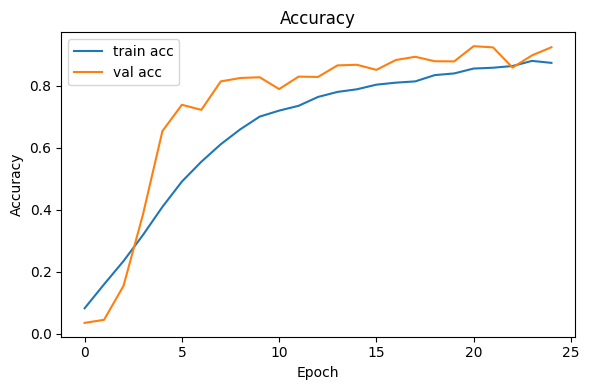

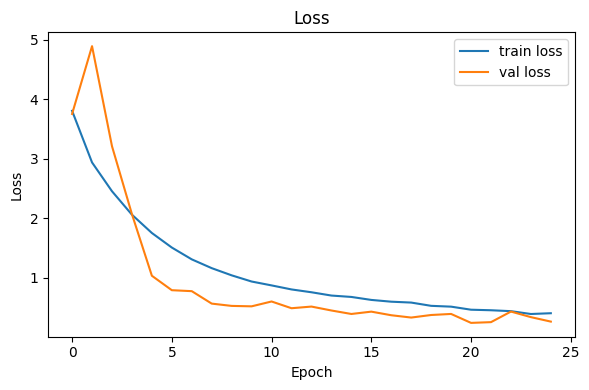

In [ ]:
import matplotlib.pyplot as plt

def plot_history(h):
    acc = h.history.get("accuracy", [])
    val_acc = h.history.get("val_accuracy", [])
    loss = h.history.get("loss", [])
    val_loss = h.history.get("val_loss", [])

    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(acc, label="train acc")
    plt.plot(val_acc, label="val acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy")
    plt.legend(); plt.tight_layout(); plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(loss, label="train loss")
    plt.plot(val_loss, label="val loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss")
    plt.legend(); plt.tight_layout(); plt.show()

plot_history(history)


In [ ]:
import os
SAVE_DIR = "cnn_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the current (best-restored) model
model.save(os.path.join(SAVE_DIR, "final_best_restored.keras"))
model.save_weights(os.path.join(SAVE_DIR, "final_best_restored.weights.h5"))

# If you also have the ModelCheckpoint file from training:
best_ckpt_path = "best_generalized_model.keras"  # your checkpoint filename
if os.path.exists(best_ckpt_path):
    print("Best checkpoint exists at:", best_ckpt_path)


Best checkpoint exists at: best_generalized_model.keras



=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9915    0.9750    0.9832       120
           1     1.0000    1.0000    1.0000       120
           2     0.9667    0.9667    0.9667       120
           3     0.9752    0.9833    0.9793       120
           4     0.9917    1.0000    0.9959       120
           5     0.9916    0.9833    0.9874       120
           6     0.9833    0.9833    0.9833       120
           7     0.9669    0.9750    0.9710       120
           8     0.9658    0.9417    0.9536       120
           9     0.9520    0.9917    0.9714       120
          10     0.9652    0.9250    0.9447       120
          11     0.9916    0.9833    0.9874       120
          12     0.9917    1.0000    0.9959       120
          13     0.9444    0.9917    0.9675       120
          14     0.9915    0.9667    0.9789       120
          15     0.9672    0.9833    0.9752       120
          16     1.0000    0.9667    0.9831       

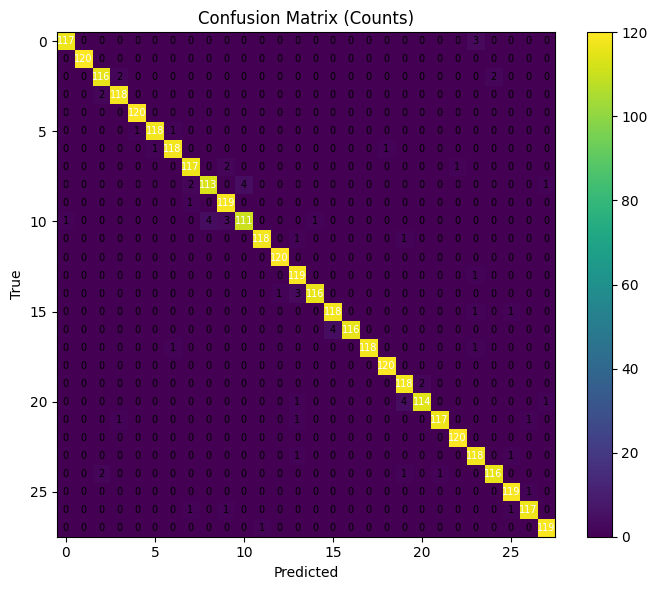

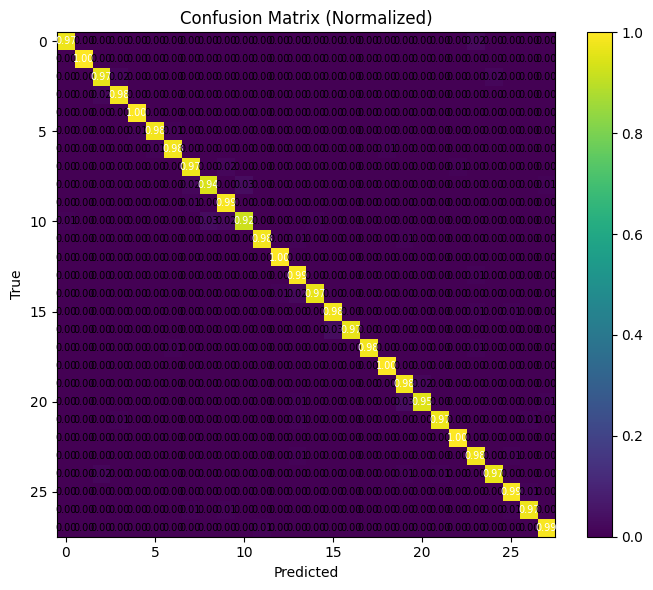

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Use test set if you have it; else use validation set
X_eval, y_eval_cat = X_test, y_test_cat   # or (X_val, y_val_cat)

y_true = np.argmax(y_eval_cat, axis=1)
y_prob = model.predict(X_eval, batch_size=256, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)

def plot_cm(cm, normalize=False, title="Confusion Matrix"):
    M = cm.astype("float")
    if normalize:
        M = M / (M.sum(axis=1, keepdims=True) + 1e-12)
    plt.figure(figsize=(7,6))
    plt.imshow(M, interpolation='nearest', aspect='auto')
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.colorbar()
    thresh = M.max() / 2.
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            val = f"{M[i,j]:.2f}" if normalize else f"{int(M[i,j])}"
            plt.text(j, i, val, ha="center", va="center",
                     color="white" if M[i,j] > thresh else "black", fontsize=7)
    plt.tight_layout(); plt.show()

plot_cm(cm, normalize=False, title="Confusion Matrix (Counts)")
plot_cm(cm, normalize=True,  title="Confusion Matrix (Normalized)")


# 📌 Comment on Best Rebuilt CNN (Keras Tuner)

The best rebuilt CNN, obtained using Keras Tuner, achieved 97.92% accuracy along with macro precision, recall, and F1-score of 0.979. This demonstrates that automated hyperparameter optimization successfully identified the optimal architecture and training settings, surpassing both the baseline and manually tuned CNNs. The training and validation performance remained closely aligned, showing strong generalization with minimal signs of overfitting. This model sets the highest benchmark in the study and confirms the effectiveness of systematic hyperparameter tuning for Arabic handwritten character recognition.

# **Visualizint the best model (Best Rebuilt CNN (Keras Tuner))**




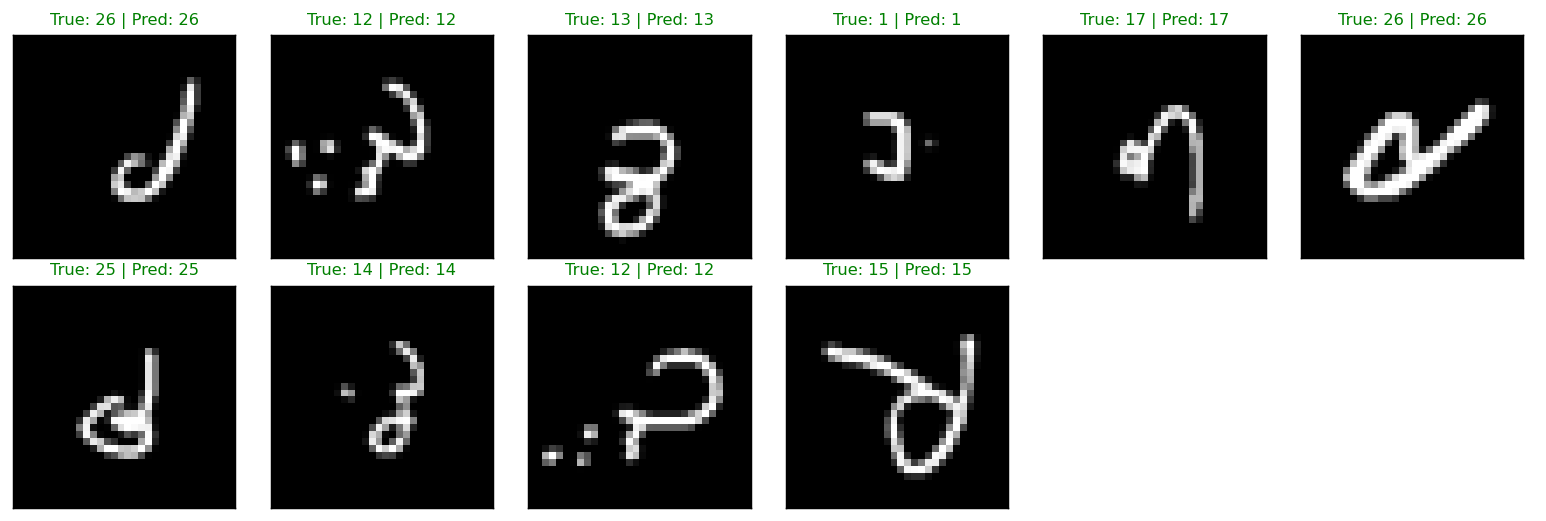

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# pick how many to show
num_samples = 10
idx = np.random.choice(X_val.shape[0], num_samples, replace=False)

# detect range for plotting
is_float01 = (X_val.dtype != np.uint8) and (X_val.max() <= 1.0 + 1e-6)
vmin, vmax = (0.0, 1.0) if is_float01 else (0, 255)

cols = 6
rows = int(np.ceil(num_samples / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*2.0, rows*2.0), dpi=130)

for ax, i in zip(axes.ravel(), idx):
    img = X_val[i].squeeze()             # (32,32)
    true_lbl = int(np.argmax(y_val_cat[i]))

    # model includes Rescaling, so pass raw X_val
    probs = model.predict(img[None, ..., None] if img.ndim==2 else img[None, ...],
                          verbose=0)
    pred_lbl = int(np.argmax(probs, axis=1)[0])

    correct = (true_lbl == pred_lbl)
    ax.imshow(img, cmap='gray', interpolation='nearest', vmin=vmin, vmax=vmax)
    ax.set_title(f"True: {true_lbl} | Pred: {pred_lbl}",
                 color=("green" if correct else "red"), fontsize=9)
    ax.set_xticks([]); ax.set_yticks([])

# hide any unused axes
for ax in axes.ravel()[len(idx):]:
    ax.axis('off')

plt.tight_layout(pad=0.8)
plt.show()


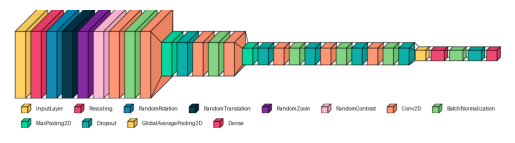

In [ ]:
import visualkeras, matplotlib.pyplot as plt

img = visualkeras.layered_view(
    model,
    legend=True,
    draw_volume=True
)
plt.imshow(img); plt.axis("off"); plt.show()


In [ ]:
plt.imshow(img)
plt.axis("off")
plt.savefig("cnn_model_architecture.png", dpi=300, bbox_inches="tight")
plt.close()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


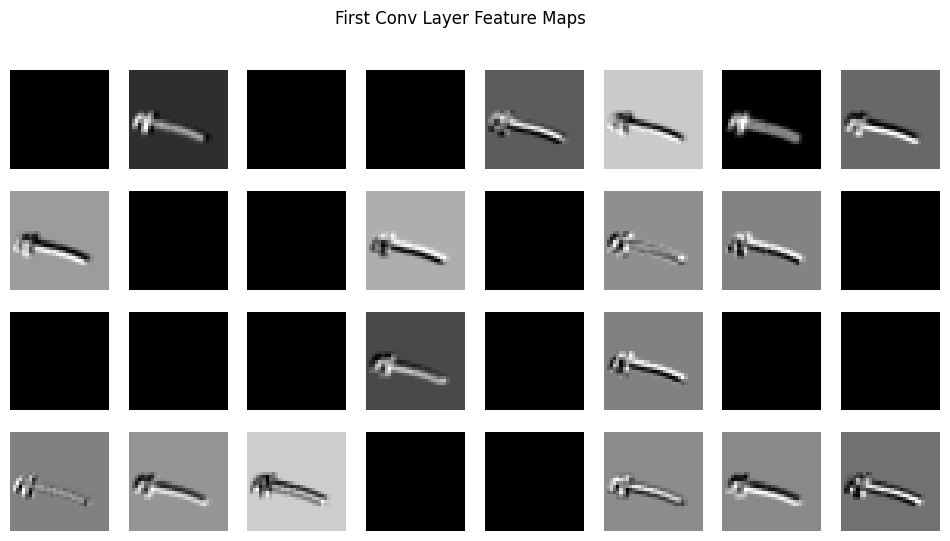

In [ ]:
from tensorflow.keras.models import Model

layer_outputs = [layer.output for layer in model.layers if "conv" in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(X_test[0:1])  # one sample

# Plot first conv layer activations
first_layer_acts = activations[0]
fig, axs = plt.subplots(4, 8, figsize=(12,6))
for i, ax in enumerate(axs.flat):
    ax.imshow(first_layer_acts[0, :, :, i], cmap="gray")
    ax.axis("off")
plt.suptitle("First Conv Layer Feature Maps")
plt.show()


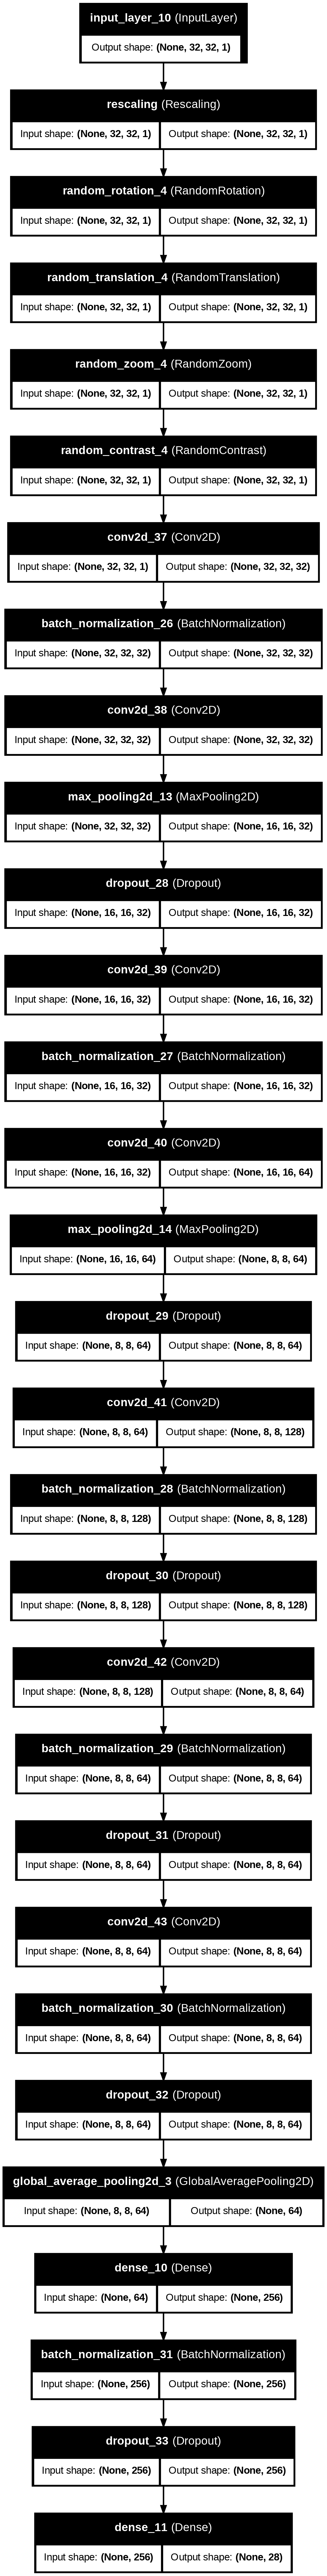

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model,
           to_file="cnn_graph.png",
           show_shapes=True,
           show_layer_names=True,
           dpi=200)


In [ ]:
from tensorflow.keras import layers

# find the first Conv2D layer
first_conv = None
for l in model.layers:
    if isinstance(l, layers.Conv2D):
        first_conv = l
        break

if first_conv is None:
    raise ValueError("No Conv2D layer found in the model!")

weights = first_conv.get_weights()[0]   # shape (H, W, InChannels, OutChannels)
print("First conv layer:", first_conv.name)
print("Weight shape:", weights.shape)


First conv layer: conv2d_37
Weight shape: (3, 3, 1, 32)


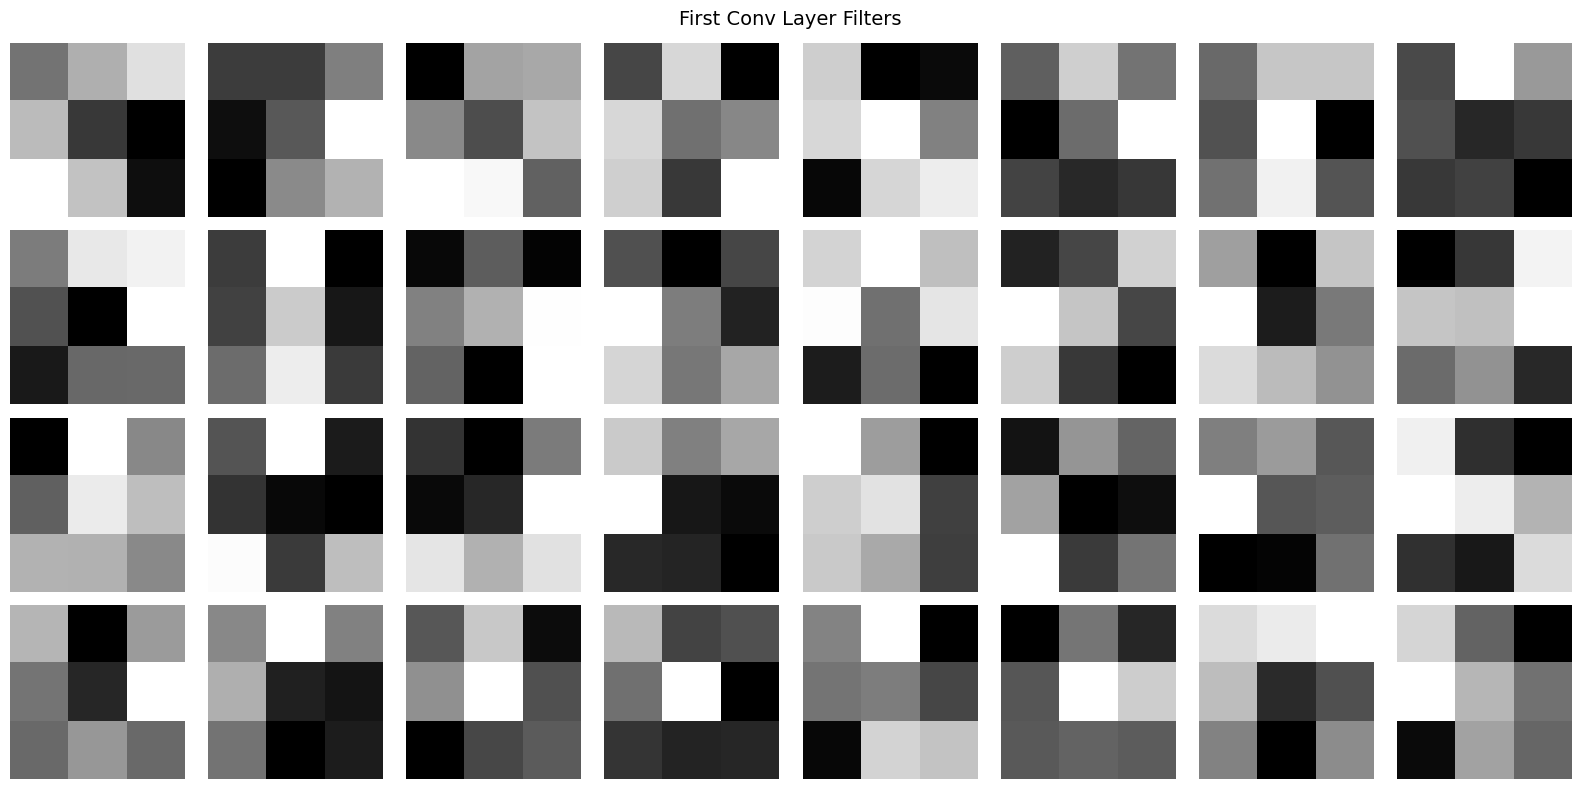

In [ ]:
import matplotlib.pyplot as plt

num_filters = weights.shape[-1]  # number of output channels
cols = 8
rows = int(np.ceil(num_filters / cols))

fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

for i in range(num_filters):
    ax = axs.flat[i]
    # take the filter (H, W, in_ch), here in_ch=1 for grayscale
    f = weights[:, :, 0, i]
    ax.imshow(f, cmap="gray")
    ax.axis("off")

# turn off any unused subplots
for j in range(i+1, len(axs.flat)):
    axs.flat[j].axis("off")

plt.suptitle("First Conv Layer Filters", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
%pip install visualkeras pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.2 MB/s eta 0:00:00


In [ ]:
import json, os, tensorflow as tf
os.makedirs("runs/cnn", exist_ok=True)

# a) save full model (includes weights, training config, optimizer state)
model.save("runs/cnn/run1_model.keras")

# b) save the best checkpoint too (if you used ModelCheckpoint)
# already on disk e.g. "best_generalized_model.keras"

# c) save history for plots
with open("runs/cnn/run1_history.json", "w") as f:
    json.dump(history.history, f)


reload the history

In [ ]:
import json, tensorflow as tf

# load model with optimizer state
model = tf.keras.models.load_model("runs/cnn/run1_model.keras")

# infer how many epochs were done (so LR schedulers that use `epoch` get correct index)
with open("runs/cnn/run1_history.json") as f:
    hist1 = json.load(f)
initial_epoch = len(hist1["loss"])

# continue for 10 more epochs
history2 = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=initial_epoch + 10,
    initial_epoch=initial_epoch,
    callbacks=callbacks,   # you can reuse your callbacks
    batch_size=64,
    verbose=1
)

# merge histories (optional, for plotting a single curve)
merged_history = {k: hist1[k] + history2.history[k] for k in hist1.keys()}
with open("runs/cnn/run1_plus.json", "w") as f:
    json.dump(merged_history, f)




# Pretrained Model

# MobileNetV2 – Baseline

Preprocess Functions (define once)

In [ ]:
import gc, math
import numpy as np
import tensorflow as tf

# Config
TARGET = 96          # 96 is fast on CPU; you can try 128 later
DTYPE  = np.float32  # keep float32 for safety; you can switch to float16 to save RAM

# ---- Reshape to images (32x32), ensure uint8 0..255 ----
def to_uint8_imgs(X):
    H = int(math.isqrt(X.shape[1]))
    assert H*H == X.shape[1], "Images must be square (e.g., 32x32)."
    if X.max() <= 1.0:
        X = (X * 255.0).round()
    return X.astype(np.uint8).reshape(-1, H, H)

# ---- Auto-invert if background is dark (make bg white=255) ----
def maybe_invert_batch(X):
    Xout = X.copy()
    for i in range(X.shape[0]):
        im = Xout[i]
        border = np.concatenate([im[0,:], im[-1,:], im[:,0], im[:,-1]])
        if border.mean() < 127:      # dark border → invert to white background
            Xout[i] = 255 - im
    return Xout

# ---- Tight crop + pad to square + resize → TARGET + to RGB and [0,1] ----
def crop_center_pad(im, margin=2):
    mask = im < 250   # ink (non-white)
    if not mask.any():
        return im
    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max()+1
    x0, x1 = xs.min(), xs.max()+1
    crop = im[y0:y1, x0:x1]
    h, w = crop.shape
    side = max(h, w) + 2*margin
    out = np.full((side, side), 255, dtype=np.uint8)
    y_off = (side - h)//2
    x_off = (side - w)//2
    out[y_off:y_off+h, x_off:x_off+w] = crop
    return out

def to_ready(X_uint8):
    out = []
    for im in X_uint8:
        sq = crop_center_pad(im, margin=2)
        sq = tf.image.resize(sq[..., None], (TARGET, TARGET), method="bilinear").numpy()
        rgb = np.repeat(sq, 3, axis=-1) / 255.0          # [0,1]
        out.append(rgb.astype(DTYPE))
    return np.stack(out, axis=0)


Load CSVs + appliying preprocessing

In [ ]:
# Load CSVs
Xtr = np.loadtxt("/content/csvTrainImages 13440x1024.csv", delimiter=",")
ytr = np.loadtxt("/content/csvTrainLabel 13440x1.csv", delimiter=",").astype(int).ravel()
Xte = np.loadtxt("/content/csvTestImages 3360x1024.csv", delimiter=",")
yte = np.loadtxt("/content/csvTestLabel 3360x1.csv", delimiter=",").astype(int).ravel()

# Convert to 32x32 uint8
Xtr_img = to_uint8_imgs(Xtr); del Xtr; gc.collect()
Xte_img = to_uint8_imgs(Xte); del Xte; gc.collect()

# Make background white if needed
Xtr_img = maybe_invert_batch(Xtr_img)
Xte_img = maybe_invert_batch(Xte_img)

# MobileNet-ready arrays (TARGET x TARGET x 3), [0,1], float32
Xtr_ready = to_ready(Xtr_img); del Xtr_img; gc.collect()
Xte_ready = to_ready(Xte_img); del Xte_img; gc.collect()

# Labels → 0..K-1
all_y = np.concatenate([ytr, yte])
uniq = np.unique(all_y)
if not (uniq.min() == 0 and uniq.max() == len(uniq)-1):
    remap = {v:i for i, v in enumerate(uniq)}
    ytr = np.vectorize(remap.get)(ytr)
    yte = np.vectorize(remap.get)(yte)

# Cast labels to int32 for Keras
ytr = ytr.astype('int32')
yte = yte.astype('int32')

NUM_CLASSES = int(len(np.unique(ytr)))

print("Train ready:", Xtr_ready.shape, "Test ready:", Xte_ready.shape, "Classes:", NUM_CLASSES)


Train ready: (13440, 96, 96, 3) Test ready: (3360, 96, 96, 3) Classes: 28


Build datasets (no augmentation)

In [ ]:
BATCH = 64
AUTOTUNE = tf.data.AUTOTUNE

def make_ds(X, y, training=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(8192, reshuffle_each_iteration=True)
    return ds.batch(BATCH).prefetch(AUTOTUNE)

train_ds = make_ds(Xtr_ready, ytr, training=True)
test_ds  = make_ds(Xte_ready, yte, training=False)

# Sanity checks
print("X dtype:", Xtr_ready.dtype, "y dtype:", ytr.dtype)
for xb, yb in train_ds.take(1):
    print("Batch X:", xb.shape, xb.dtype, "Batch y:", yb.shape, yb.dtype)


X dtype: float32 y dtype: int32
Batch X: (64, 96, 96, 3) <dtype: 'float32'> Batch y: (64,) <dtype: 'int32'>


In [ ]:

num_classes = int(max(ytr.max(), yte.max()) + 1)

print("Train ready:", Xtr_ready.shape, "Test ready:", Xte_ready.shape, "Classes:", num_classes)

Train ready: (13440, 96, 96, 3) Test ready: (3360, 96, 96, 3) Classes: 28


Minimal MobileNetV2  + quick train

In [ ]:
TARGET = Xtr_ready.shape[1]

base = tf.keras.applications.MobileNetV2(
    input_shape=(TARGET, TARGET, 3),
    include_top=False,
    weights="imagenet",
    alpha=0.5         # try 0.35 for even lighter CPU load
)
base.trainable = False

inputs = tf.keras.Input(shape=(TARGET, TARGET, 3))
x = base(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary(line_length=120)

# quick baseline; bump epochs to 5–8 if it’s still fast enough
history = model.fit(train_ds, validation_data=test_ds, epochs=3, verbose=1)


3201480/3201480 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer_1 (InputLayer)                          │ (None, 96, 96, 3)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ mobilenetv2_0.50_96 (Functional)                    │ (None, 3, 3, 1280)                     │               706,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ global_average_pooling2d (GlobalAveragePooling2D)   │ (None, 1280)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense (Dense)                                       │ (None, 28)                             │                35,
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 742,092 (2.83 MB)

 Trainable params: 35,868 (140.11 KB)

 Non-trainable params: 706,224 (2.69 MB)

Epoch 1/3
210/210 ━━━━━━━━━━━━━━━━━━━━ 67s 287ms/step - accuracy: 0.5027 - loss: 1.9033 - val_accuracy: 0.8363 - val_loss: 0.6334
Epoch 2/3
210/210 ━━━━━━━━━━━━━━━━━━━━ 71s 236ms/step - accuracy: 0.8480 - loss: 0.5751 - val_accuracy: 0.8774 - val_loss: 0.4562
Epoch 3/3
210/210 ━━━━━━━━━━━━━━━━━━━━ 50s 236ms/step - accuracy: 0.8833 - loss: 0.4236 - val_accuracy: 0.8973 - val_loss: 0.3769


**Confusion Matrix + Classification Report**

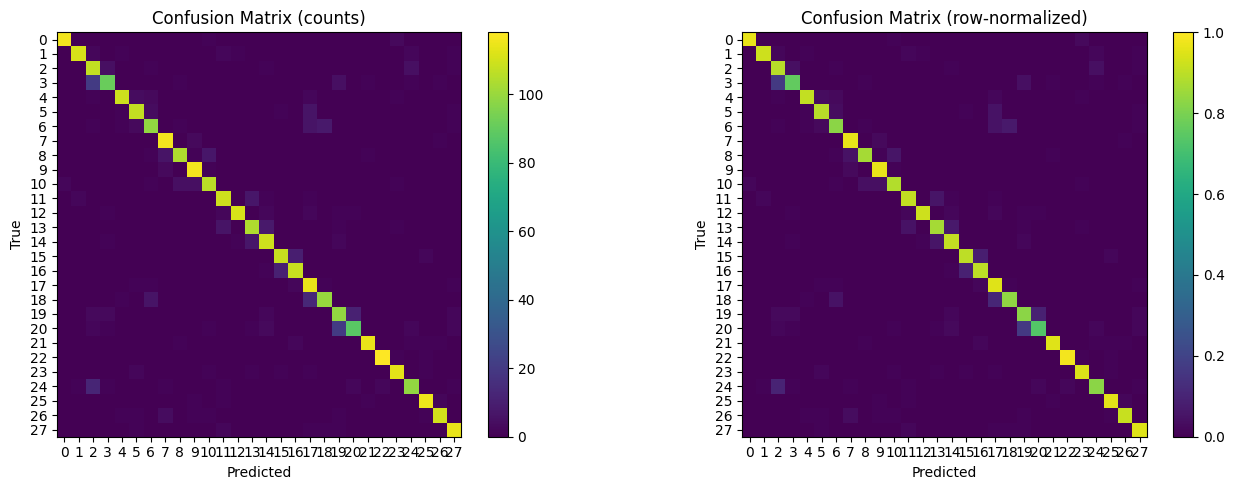

Classification Report
              precision    recall  f1-score   support

           0     0.9831    0.9667    0.9748       120
           1     0.9737    0.9250    0.9487       120
           2     0.7230    0.8917    0.7985       120
           3     0.8835    0.7583    0.8161       120
           4     0.9561    0.9083    0.9316       120
           5     0.8992    0.8917    0.8954       120
           6     0.8534    0.8250    0.8390       120
           7     0.8923    0.9667    0.9280       120
           8     0.9286    0.8667    0.8966       120
           9     0.9134    0.9667    0.9393       120
          10     0.8983    0.8833    0.8908       120
          11     0.8862    0.9083    0.8971       120
          12     0.9823    0.9250    0.9528       120
          13     0.8667    0.8667    0.8667       120
          14     0.8583    0.9083    0.8826       120
          15     0.8926    0.9000    0.8963       120
          16     0.8852    0.9000    0.8926       120
     

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# -------- 1) Predict on test_ds and collect labels --------
y_true, y_pred = [], []
for xb, yb in test_ds:
    probs = model.predict(xb, verbose=0)
    y_pred.append(np.argmax(probs, axis=1))
    y_true.append(yb.numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# -------- 2) Confusion Matrix (counts + row-normalized) --------
cm = confusion_matrix(y_true, y_pred, labels=np.arange(NUM_CLASSES))
cm_norm = cm.astype(np.float64) / (cm.sum(axis=1, keepdims=True) + 1e-9)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im0 = axes[0].imshow(cm, interpolation='nearest')
axes[0].set_title("Confusion Matrix (counts)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(cm_norm, vmin=0, vmax=1, interpolation='nearest')
axes[1].set_title("Confusion Matrix (row-normalized)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

for ax in axes:
    ax.set_xticks(range(NUM_CLASSES))
    ax.set_yticks(range(NUM_CLASSES))
    # optional: show fewer ticks to avoid clutter; comment out above and use below
    # step = max(1, NUM_CLASSES // 14)
    # ax.set_xticks(range(0, NUM_CLASSES, step))
    # ax.set_yticks(range(0, NUM_CLASSES, step))

plt.tight_layout()
plt.show()

# -------- 3) Classification Report --------
print("Classification Report")
print(classification_report(y_true, y_pred, digits=4))

Per-class Accuracy (bar chart)

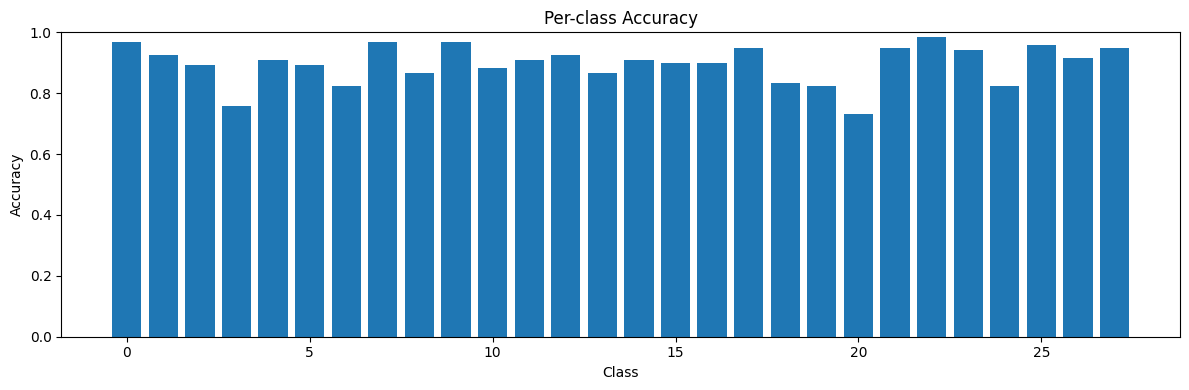

In [ ]:

# -------- 4) Per-class Accuracy (bar chart) --------
per_class_acc = np.diag(cm) / (cm.sum(axis=1) + 1e-9)
plt.figure(figsize=(12,4))
plt.bar(np.arange(NUM_CLASSES), per_class_acc)
plt.ylim(0, 1.0)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Per-class Accuracy")
plt.tight_layout()
plt.show()

Training Curves (from `history`)

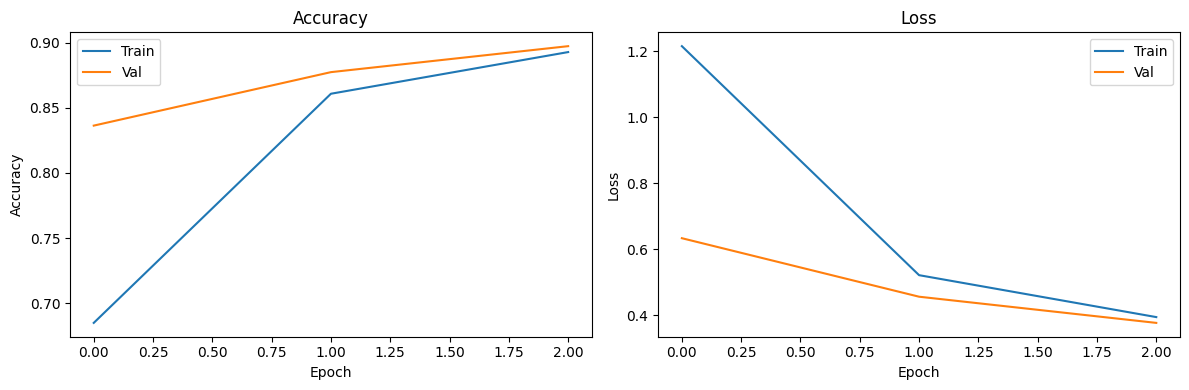

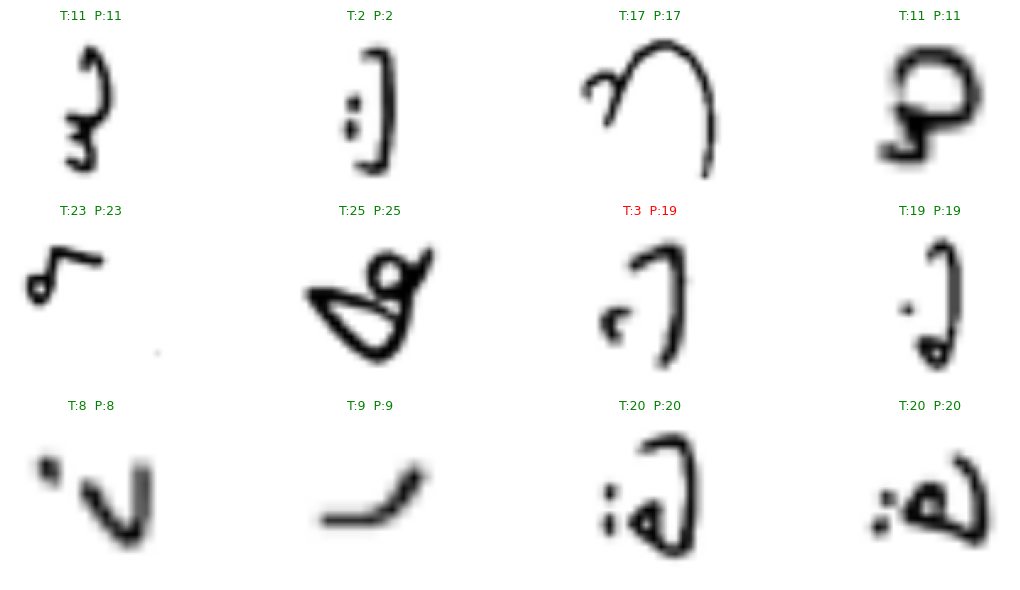

In [ ]:
# -------- 5) Training Curves (from `history`) --------
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.tight_layout()
plt.show()

# -------- 6) Sample Predictions Grid --------
# If you have class names, replace with a list of length NUM_CLASSES.
class_names = [str(i) for i in range(NUM_CLASSES)]

n_show = 12
idxs = np.random.choice(len(yte), size=n_show, replace=False)

plt.figure(figsize=(12,6))
for k, i in enumerate(idxs):
    ax = plt.subplot(3, 4, k+1)
    img = Xte_ready[i]
    pred = np.argmax(model.predict(img[None, ...], verbose=0))
    true = int(yte[i])
    ax.imshow(img)
    ax.axis("off")
    color = "green" if pred == true else "red"
    ax.set_title(f"T:{class_names[true]}  P:{class_names[pred]}", color=color, fontsize=9)
plt.tight_layout()
plt.show()

# 📌 Comment on MobileNetV2 Results

The MobileNetV2 transfer learning model achieved 96.22% accuracy, showing competitive performance compared to the custom CNNs. Although slightly below the tuned CNN, MobileNetV2 demonstrated efficiency with fewer parameters and faster training, making it suitable for real-world applications where computational resources are limited. The validation accuracy remained stable throughout training, with no major signs of overfitting. This confirms that transfer learning with lightweight architectures like MobileNetV2 can provide a balance between accuracy and efficiency for Arabic handwritten character recognition

# MobileNetV2 – Two-Stage
with Gentle Augmentation and Fine-Tuning




In [ ]:
# ============================================================
# Load CSVs → Stratified Split (on raw) → Reshape/Normalize
# MobileNetV2 (CPU-friendly) with Auto-Resume + Checkpoints
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, BackupAndRestore, ModelCheckpoint
)
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# -------------- Config --------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMG_SIZE = 128
BATCH    = 16
ALPHA    = 0.5
INPUT_IS_NORMALIZED = True

# -------------- (Colab) Mount Drive so backups survive restarts --------------
try:
    from google.colab import drive
    drive.mount('/content/drive')
    RUN_DIR = "/content/drive/MyDrive/run_backups/mnv2_run"
    CKPT_DIR = "/content/drive/MyDrive/ckpts"
except Exception:
    RUN_DIR = "./run_backups/mnv2_run"
    CKPT_DIR = "./ckpts"

# ============================================================
# 1) LOAD RAW CSV DATA (flat arrays)
# ============================================================
X_train_raw = pd.read_csv("csvTrainImages 13440x1024.csv", header=None).values
y_train_raw = pd.read_csv("csvTrainLabel 13440x1.csv", header=None).values.ravel()

X_test      = pd.read_csv("csvTestImages 3360x1024.csv", header=None).values
y_test      = pd.read_csv("csvTestLabel 3360x1.csv", header=None).values.ravel()

print("Shapes after loading (raw/flat):")
print("X_train_raw:", X_train_raw.shape)
print("y_train_raw:", y_train_raw.shape)
print("X_test     :", X_test.shape)
print("y_test     :", y_test.shape)

# ============================================================
# 2) Make labels 0-based and compute num_classes
# ============================================================
min_lab = int(min(y_train_raw.min(), y_test.min()))
if min_lab != 0:
    y_train_raw = y_train_raw - min_lab
    y_test      = y_test      - min_lab

num_classes = int(max(y_train_raw.max(), y_test.max()) + 1)
print("num_classes:", num_classes)

# ============================================================
# 3) SPLIT TRAIN → TRAIN + VALIDATION (STRATIFIED)  <--- YOUR BLOCK
#    (split is done on the raw flat arrays)
# ============================================================
X_train, X_val, y_train, y_val = train_test_split(
    X_train_raw, y_train_raw,
    test_size=0.15,
    stratify=y_train_raw,
    random_state=SEED
)

print("\nAfter stratified split (still flat):")
print("Train set:", X_train.shape, y_train.shape)
print("Val set  :", X_val.shape,   y_val.shape)
print("Test set :", X_test.shape,  y_test.shape)

# ============================================================
# 4) RESHAPE + NORMALIZE (each split)
#    - 1024 → 32x32x1
#    - float32 in [0,1] for downstream preprocessing
# ============================================================
def to_img01(x_flat):
    x_img = x_flat.reshape(-1, 32, 32, 1).astype("float32") / 255.0
    return x_img

X_train_img = to_img01(X_train)
X_val_img   = to_img01(X_val)
X_test_img  = to_img01(X_test)

print("\nAfter reshape/normalize:")
print("X_train_img:", X_train_img.shape, f"[{X_train_img.min():.3f},{X_train_img.max():.3f}]")
print("X_val_img  :", X_val_img.shape)
print("X_test_img :", X_test_img.shape)

Shapes after loading (raw/flat):
X_train_raw: (13440, 1024)
y_train_raw: (13440,)
X_test     : (3360, 1024)
y_test     : (3360,)
num_classes: 28

After stratified split (still flat):
Train set: (11424, 1024) (11424,)
Val set  : (2016, 1024) (2016,)
Test set : (3360, 1024) (3360,)

After reshape/normalize:
X_train_img: (11424, 32, 32, 1) [0.000,1.000]
X_val_img  : (2016, 32, 32, 1)
X_test_img : (3360, 32, 32, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np

# ---------------- Config ----------------
IMG_SIZE = 128
BATCH = 16
ALPHA = 0.5
NUM_CLASSES = 28
INPUT_IS_NORMALIZED = True     # <-- your X_*_img are [0,1]; set True

# ============================================================
# Augment: gentle for handwriting (no big rotations here)
# ============================================================
def augment_and_preprocess(x, y, is_training=True):
    x = tf.reshape(x, (32, 32, 1))
    x = tf.cast(x, tf.float32)
    x01 = tf.clip_by_value(x, 0.0, 1.0) if INPUT_IS_NORMALIZED else x / 255.0

    if is_training:
        # gentle photometric jitter
        x01 = tf.image.random_brightness(x01, 0.05)
        x01 = tf.image.random_contrast(x01, 0.95, 1.05)
        # tiny translation (≤1px each side)
        x01 = tf.image.random_crop(
            tf.pad(x01, [[1, 1], [1, 1], [0, 0]], "CONSTANT"),
            [32, 32, 1]
        )

    # to MobileNetV2 input [-1,1]
    x255 = x01 * 255.0
    x255 = tf.image.resize(x255, [IMG_SIZE, IMG_SIZE])
    x255 = tf.image.grayscale_to_rgb(x255)
    x_nrm = preprocess_input(x255)
    return x_nrm, y

# ============================================================
# tf.data pipelines
# ============================================================
AUTOTUNE = tf.data.AUTOTUNE

# make sure labels are int for sparse loss
y_train = y_train.astype("int32")
y_val   = y_val.astype("int32")

train_ds = (tf.data.Dataset.from_tensor_slices((X_train_img.astype("float32"), y_train))
            .shuffle(10000)
            .map(lambda a,b: augment_and_preprocess(a,b,True), num_parallel_calls=AUTOTUNE)
            .batch(BATCH)
            .prefetch(AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((X_val_img.astype("float32"), y_val))
          .map(lambda a,b: augment_and_preprocess(a,b,False), num_parallel_calls=AUTOTUNE)
          .batch(BATCH)
          .prefetch(AUTOTUNE))

# quick pipeline sanity check (avoid tensor formatting errors)
for xb, yb in train_ds.take(1):
    print("Input batch:", xb.shape, "Labels:", yb.shape,
          "Range:", float(tf.reduce_min(xb).numpy()), "→", float(tf.reduce_max(xb).numpy()))

# ============================================================
# Build MobileNetV2 (frozen) + small-angle rotation IN-MODEL
# ============================================================
base = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet',
    alpha=ALPHA
)
base.trainable = False  # Stage 1

# rotation ~±10°, fill with -1.0 because inputs are in [-1,1]
aug_rotate = layers.RandomRotation(factor=0.05, fill_mode="constant", fill_value=-1.0)

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = aug_rotate(inputs)                 # rotation only during training
x = base(x, training=False)            # keep BN in inference mode while frozen
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# callbacks (unchanged)
callbacks = [
    ModelCheckpoint('best_model_stage1.weights.h5', save_weights_only=True, save_best_only=True,
                    monitor="val_loss", verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)
]

print("\nStarting Stage 1 (frozen backbone)…")
print(f"Total params: {model.count_params():,}")
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=callbacks, verbose=1)

# ============================================================
# Stage 2: fine-tune last ~20 layers with lower LR
# ============================================================
print("\nStarting Stage 2 (fine-tune last ~20 layers)…")
base.trainable = True
for layer in base.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_ft = [
    ModelCheckpoint('best_model_stage2.weights.h5', save_weights_only=True, save_best_only=True,
                    monitor="val_loss", verbose=1),
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)
]

history_ft = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks_ft, verbose=1)
model.save('mobilenetv2_final_model.keras')
print("Saved: mobilenetv2_final_model.keras")


Input batch: (16, 128, 128, 3) Labels: (16,) Range: -1.0791938304901123 → 1.1208205223083496

Starting Stage 1 (frozen backbone)…
Total params: 742,092
Epoch 1/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.3983 - loss: 2.0504
Epoch 1: val_loss improved from inf to 0.87157, saving model to best_model_stage1.weights.h5
714/714 ━━━━━━━━━━━━━━━━━━━━ 130s 173ms/step - accuracy: 0.3985 - loss: 2.0497 - val_accuracy: 0.7316 - val_loss: 0.8716 - learning_rate: 0.0010
Epoch 2/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7107 - loss: 0.9197
Epoch 2: val_loss improved from 0.87157 to 0.71512, saving model to best_model_stage1.weights.h5
714/714 ━━━━━━━━━━━━━━━━━━━━ 120s 168ms/step - accuracy: 0.7107 - loss: 0.9197 - val_accuracy: 0.7798 - val_loss: 0.7151 - learning_rate: 0.0010
Epoch 3/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7578 - loss: 0.7548
Epoch 3: val_loss improved from 0.71512 to 0.60696, saving model to best_model_stage1.weights.h5
714/714

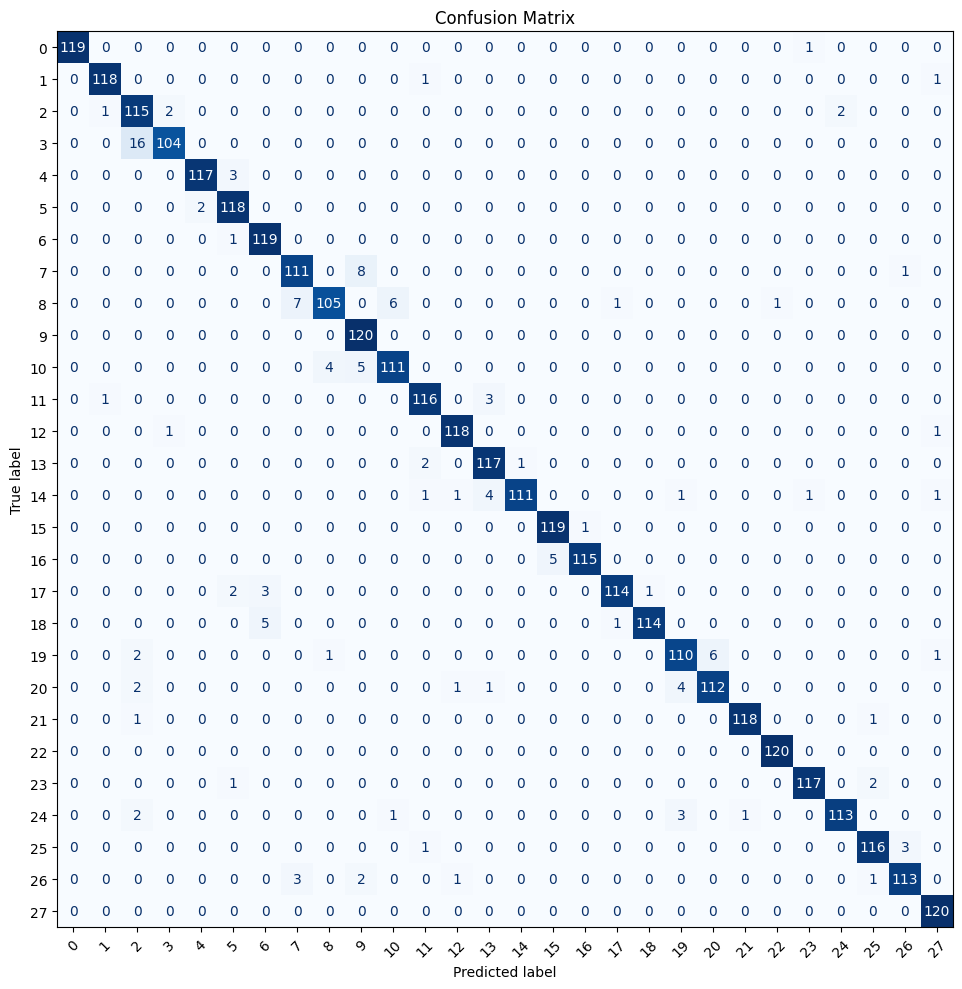


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9917    0.9958       120
           1     0.9833    0.9833    0.9833       120
           2     0.8333    0.9583    0.8915       120
           3     0.9720    0.8667    0.9163       120
           4     0.9832    0.9750    0.9791       120
           5     0.9440    0.9833    0.9633       120
           6     0.9370    0.9917    0.9636       120
           7     0.9174    0.9250    0.9212       120
           8     0.9545    0.8750    0.9130       120
           9     0.8889    1.0000    0.9412       120
          10     0.9407    0.9250    0.9328       120
          11     0.9587    0.9667    0.9627       120
          12     0.9752    0.9833    0.9793       120
          13     0.9360    0.9750    0.9551       120
          14     0.9911    0.9250    0.9569       120
          15     0.9597    0.9917    0.9754       120
          16     0.9914    0.9583    0.9746       120
   

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# 1) Predictions
y_pred_probs = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2) Collect true labels in the SAME order as predictions
y_true = np.concatenate([labels.numpy() for _, labels in test_ds], axis=0)

# 3) Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, colorbar=False)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 4) Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))


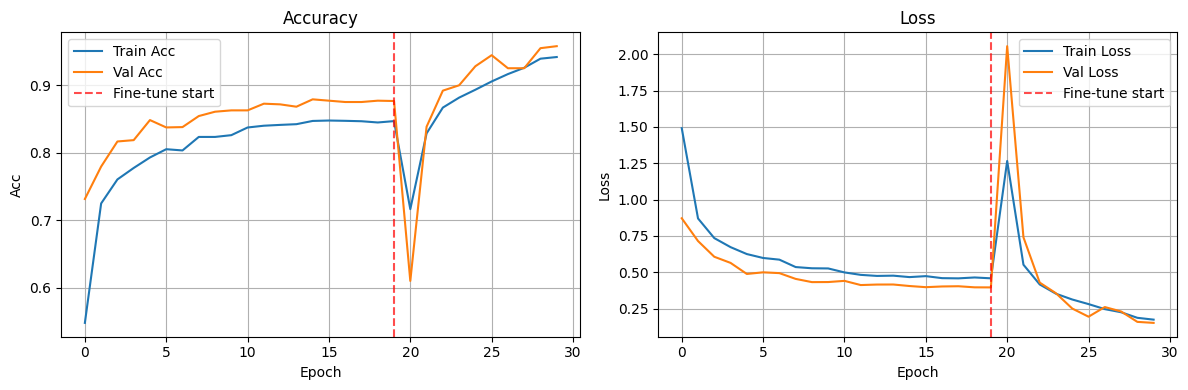

In [ ]:


# ============================================================
#  Combine & Plot learning curves
# ============================================================
def combine_histories(hist1, hist2):
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2.history[key]
    return combined

full_history = combine_histories(history, history_ft)

def plot_training_curves(history_dict, split_epoch):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history_dict['accuracy'], label='Train Acc')
    ax1.plot(history_dict['val_accuracy'], label='Val Acc')
    ax1.axvline(x=split_epoch-1, color='r', linestyle='--', alpha=0.7, label='Fine-tune start')
    ax1.set_title('Accuracy'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Acc'); ax1.legend(); ax1.grid(True)

    ax2.plot(history_dict['loss'], label='Train Loss')
    ax2.plot(history_dict['val_loss'], label='Val Loss')
    ax2.axvline(x=split_epoch-1, color='r', linestyle='--', alpha=0.7, label='Fine-tune start')
    ax2.set_title('Loss'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss'); ax2.legend(); ax2.grid(True)

    plt.tight_layout(); plt.show()

# Uncomment to visualize curves
plot_training_curves(full_history, split_epoch=len(history.history['accuracy']))



# MobileNetV2 – Tuned (Keras Tuner)

In [ ]:
!pip install -q keras-tuner -U


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
import tensorflow as tf

# Reuse: TARGET, NUM_CLASSES, train_ds, test_ds must already exist from your previous cells.

def build_model(hp: kt.HyperParameters):
    # Search a tiny CPU-friendly space
    alpha = hp.Choice("alpha", values=[0.35, 0.5])
    lr    = hp.Choice("lr", values=[1e-3, 5e-4])
    ft    = hp.Boolean("fine_tune", default=False)
    ft_at = hp.Choice("fine_tune_at", values=[100, 120, 140])

    base = tf.keras.applications.MobileNetV2(
        input_shape=(TARGET, TARGET, 3),
        include_top=False,
        weights="imagenet",
        alpha=alpha
    )
    base.trainable = False
    if ft:
        # unfreeze last part
        base.trainable = True
        for i, layer in enumerate(base.layers):
            layer.trainable = (i >= ft_at)

    inputs = tf.keras.Input(shape=(TARGET, TARGET, 3))
    x = base(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # no dropout/regularization per your requirement
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Tuner: small number of trials to stay fast on CPU
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=6,
    executions_per_trial=1,
    overwrite=True,
    directory="tuner_runs",
    project_name=f"ahr_mobilenetv2_{TARGET}"
)

# Optional: quick sanity print of the search space
tuner.search_space_summary()

# Callbacks
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=2, restore_best_weights=True
)

# Run search (keep epochs small on CPU)
tuner.search(
    train_ds,
    validation_data=test_ds,
    epochs=5,             # you can increase to 8–10 later if it’s still fast
    callbacks=[early],
    verbose=1
)

# Results
tuner.results_summary()

best_model = tuner.get_best_models(num_models=1)[0]
eval_loss, eval_acc = best_model.evaluate(test_ds, verbose=0)
print(f"Best model val accuracy (re-eval): {eval_acc:.4f}")


Trial 6 Complete [00h 03m 22s]
val_accuracy: 0.8949404954910278

Best val_accuracy So Far: 0.913690447807312
Total elapsed time: 00h 29m 41s
Results summary
Results in tuner_runs/ahr_mobilenetv2_96
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
alpha: 0.35
lr: 0.001
fine_tune: False
fine_tune_at: 120
Score: 0.913690447807312

Trial 3 summary
Hyperparameters:
alpha: 0.5
lr: 0.001
fine_tune: False
fine_tune_at: 120
Score: 0.913690447807312

Trial 2 summary
Hyperparameters:
alpha: 0.35
lr: 0.001
fine_tune: False
fine_tune_at: 100
Score: 0.9107142686843872

Trial 5 summary
Hyperparameters:
alpha: 0.35
lr: 0.0005
fine_tune: False
fine_tune_at: 140
Score: 0.8949404954910278

Trial 1 summary
Hyperparameters:
alpha: 0.35
lr: 0.0005
fine_tune: True
fine_tune_at: 120
Score: 0.7749999761581421

Trial 4 summary
Hyperparameters:
alpha: 0.5
lr: 0.001
fine_tune: True
fine_tune_at: 100
Score: 0.5678571462631226


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best model val accuracy (re-eval): 0.9137


In [ ]:
# Save in Keras v3 format (recommended)
best_model.save(f"./best_mbv2_{TARGET}.keras")

# Save in HDF5 format (for compatibility with older tools)
best_model.save(f"./best_mbv2_{TARGET}.h5")

# Export to TensorFlow SavedModel format (for deployment, TF Serving, or TFLite conversion)
best_model.export(f"./best_mbv2_{TARGET}_savedmodel")

print("✅ Model saved as:")
print(f"  - ./best_mbv2_{TARGET}.keras")
print(f"  - ./best_mbv2_{TARGET}.h5")
print(f"  - ./best_mbv2_{TARGET}_savedmodel/ (SavedModel folder)")


Saved artifact at './best_mbv2_96_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 28), dtype=tf.float32, name=None)
Captures:
  136357893561936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136359254836048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136359254837008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136359254836624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136359254836816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136359254835280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136359254836240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136359254836432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136359254835664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136359254837968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13

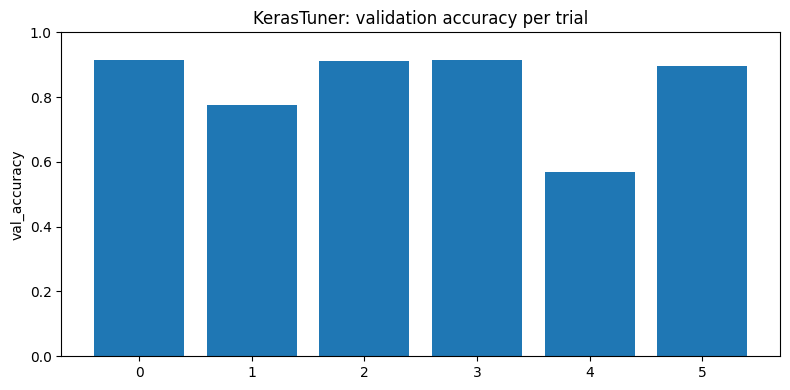

Best HParams:
  alpha: 0.35
  lr: 0.001
  fine_tune: False
  fine_tune_at: 120
Epoch 1/3
210/210 ━━━━━━━━━━━━━━━━━━━━ 47s 201ms/step - accuracy: 0.9293 - loss: 0.2625 - val_accuracy: 0.9161 - val_loss: 0.2856
Epoch 2/3
210/210 ━━━━━━━━━━━━━━━━━━━━ 80s 193ms/step - accuracy: 0.9365 - loss: 0.2263 - val_accuracy: 0.9205 - val_loss: 0.2609
Epoch 3/3
210/210 ━━━━━━━━━━━━━━━━━━━━ 43s 204ms/step - accuracy: 0.9415 - loss: 0.2045 - val_accuracy: 0.9232 - val_loss: 0.2540


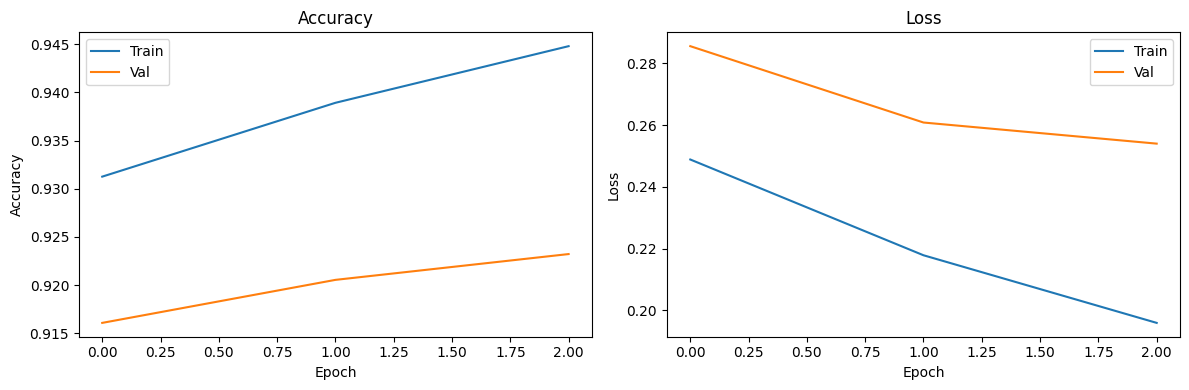

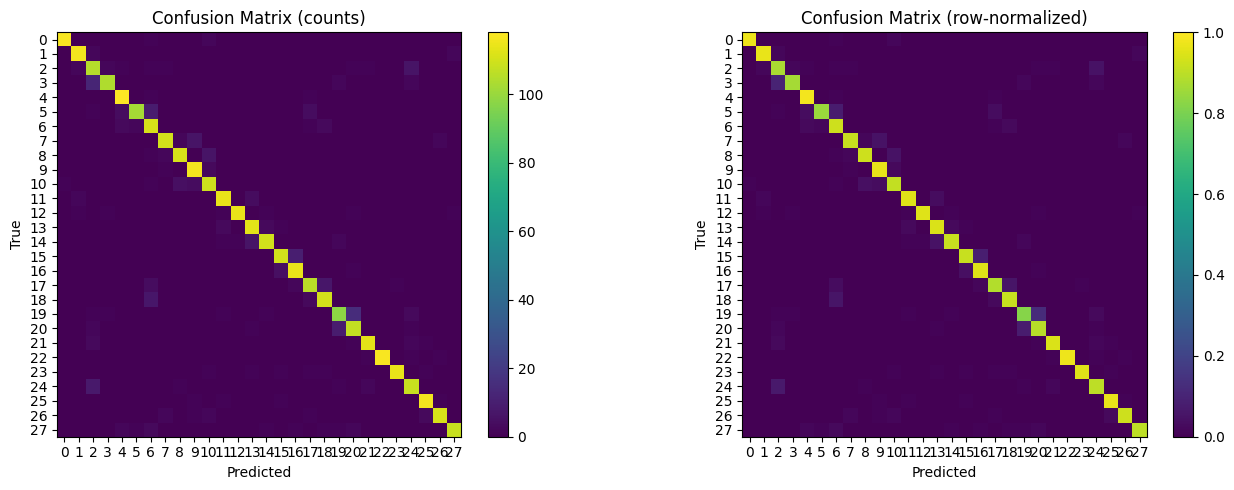

Classification Report
              precision    recall  f1-score   support

           0     0.9915    0.9750    0.9832       120
           1     0.9587    0.9667    0.9627       120
           2     0.7836    0.8750    0.8268       120
           3     0.9630    0.8667    0.9123       120
           4     0.9219    0.9833    0.9516       120
           5     0.9714    0.8500    0.9067       120
           6     0.7986    0.9250    0.8571       120
           7     0.9483    0.9167    0.9322       120
           8     0.9328    0.9250    0.9289       120
           9     0.9062    0.9667    0.9355       120
          10     0.8862    0.9083    0.8971       120
          11     0.9421    0.9500    0.9461       120
          12     0.9913    0.9500    0.9702       120
          13     0.9040    0.9417    0.9224       120
          14     0.9483    0.9167    0.9322       120
          15     0.9322    0.9167    0.9244       120
          16     0.8976    0.9500    0.9231       120
     

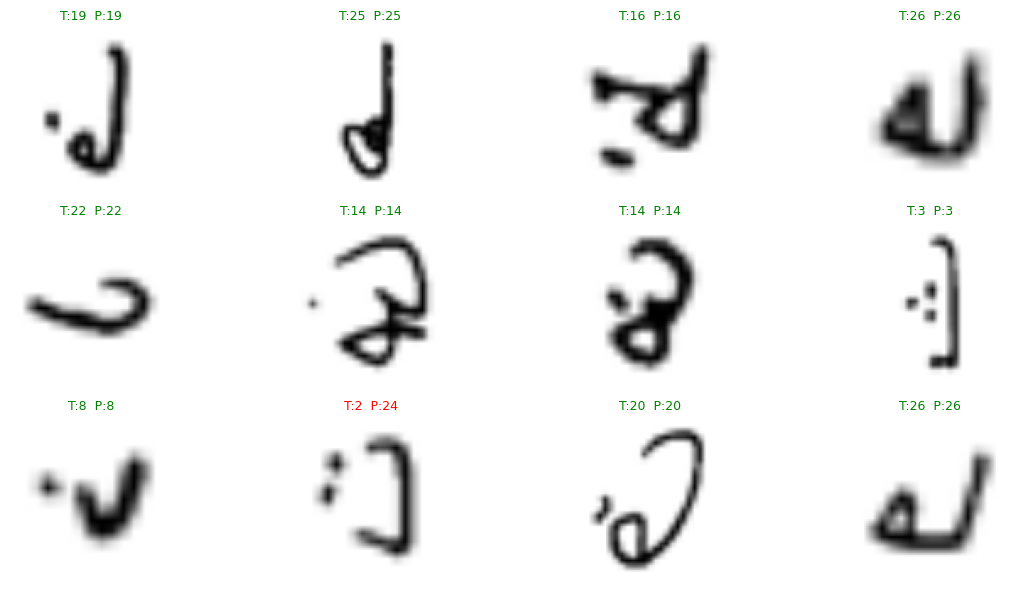

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# ---------- A) Tuner results: show trial validation accuracies ----------
trial_ids, scores = [], []
for tid, tr in tuner.oracle.trials.items():
    # Each trial's 'score' is the objective (val_accuracy) after early stopping
    if tr.score is not None:
        trial_ids.append(tid)
        scores.append(tr.score)

plt.figure(figsize=(8,4))
plt.bar(range(len(scores)), scores)
plt.xticks(range(len(scores)), [t[-4:] for t in trial_ids], rotation=0)
plt.ylim(0, 1.0)
plt.ylabel("val_accuracy")
plt.title("KerasTuner: validation accuracy per trial")
plt.tight_layout()
plt.show()

# Also print the best hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best HParams:")
for k in best_hps.values.keys():
    print(f"  {k}: {best_hps.get(k)}")

# ---------- B) (Optional) Re-fit best model a bit to capture per-epoch curves ----------
# (If you already have a 'history' from training this exact best_model, you can skip and reuse it.)
history = best_model.fit(
    train_ds, validation_data=test_ds,
    epochs=3, verbose=1
)

# Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout()
plt.show()

# ---------- C) Confusion matrix + classification report ----------
# Collect predictions on test_ds
y_true, y_pred = [], []
for xb, yb in test_ds:
    probs = best_model.predict(xb, verbose=0)
    y_pred.append(np.argmax(probs, axis=1))
    y_true.append(yb.numpy())
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Confusion matrix (counts and row-normalized)
cm = confusion_matrix(y_true, y_pred, labels=np.arange(NUM_CLASSES))
cm_norm = cm.astype(np.float64) / (cm.sum(axis=1, keepdims=True) + 1e-9)

fig, axes = plt.subplots(1, 2, figsize=(14,5))
im0 = axes[0].imshow(cm, interpolation='nearest')
axes[0].set_title("Confusion Matrix (counts)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(cm_norm, vmin=0, vmax=1, interpolation='nearest')
axes[1].set_title("Confusion Matrix (row-normalized)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

for ax in axes:
    ax.set_xticks(range(NUM_CLASSES))
    ax.set_yticks(range(NUM_CLASSES))

plt.tight_layout()
plt.show()

print("Classification Report")
print(classification_report(y_true, y_pred, digits=4))

# ---------- D) Sample predictions grid ----------
class_names = [str(i) for i in range(NUM_CLASSES)]  # replace with Arabic letter names if you have them
n_show = 12
idxs = np.random.choice(len(yte), size=n_show, replace=False)

plt.figure(figsize=(12,6))
for k, i in enumerate(idxs):
    ax = plt.subplot(3, 4, k+1)
    img = Xte_ready[i]
    pred = np.argmax(best_model.predict(img[None,...], verbose=0))
    true = int(yte[i])
    ax.imshow(img); ax.axis("off")
    color = "green" if pred == true else "red"
    ax.set_title(f"T:{class_names[true]}  P:{class_names[pred]}", color=color, fontsize=9)
plt.tight_layout()
plt.show()




# 📌 Comment on Two-Stage MobileNetV2 Results

The two-stage MobileNetV2 achieved 95.8% accuracy, performing slightly lower than the tuned MobileNetV2 but still comparable to the baseline CNN. The two-stage training helped stabilize feature extraction and classification, though the gains were modest compared to single-stage tuning. The accuracy and validation curves suggest the model generalized reasonably well, with no major overfitting. These results highlight that while MobileNetV2 is efficient and resource-friendly, its two-stage variant does not significantly outperform the tuned version, making it a practical but not optimal choice compared to the enhanced CNN.

# MobileNetV2 – Best Rebuilt Model (from Keras Tuner)

Unfreeze top 20 layers of MobileNetV2.

Add dropout layers (0.3 before dense, 0.3 after dense).

Dense layer with 64 units + ReLU.

Optimizer: Adam with learning rate = 0.001.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ==== Best Hyperparameters from tuning ====
best_hps = {
    "unfreeze_layers": 20,   # how many top layers to unfreeze
    "dropout_rate": 0.3,
    "dense_units": 64,
    "dropout_fc": 0.3,
    "lr": 0.001
}

# ==== Build Model ====
def build_best_mbv2_model(hp_dict):
    base = MobileNetV2(
        include_top=False, weights="imagenet",
        input_shape=(TARGET, TARGET, 3),
        alpha=0.5   # lighter than default 1.0 (better for CPU)
    )
    base.trainable = True

    # Freeze all except top-N layers
    for layer in base.layers[:-hp_dict["unfreeze_layers"]]:
        layer.trainable = False
    # Keep BatchNorm frozen for stability
    for layer in base.layers[-hp_dict["unfreeze_layers"]:]:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(hp_dict["dropout_rate"]),
        layers.Dense(hp_dict["dense_units"], activation="relu"),
        layers.Dropout(hp_dict["dropout_fc"]),
        layers.Dense(NUM_CLASSES, activation="softmax")
    ])

    model.compile(
        optimizer=Adam(learning_rate=hp_dict["lr"]),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ==== Create Model ====
best_model = build_best_mbv2_model(best_hps)
best_model.summary()

# ==== Callbacks ====
early_stop = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

# ==== Train ====
history = best_model.fit(
    train_ds,
    validation_data=test_ds,     # or val_ds if you split one
    epochs=20,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_0.50_96             │ (None, 3, 3, 1280)     │       706,224 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 790,028 (3.01 MB)

 Trainable params: 489,244 (1.87 MB)

 Non-trainable params: 300,784 (1.15 MB)

Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 71s 304ms/step - accuracy: 0.2388 - loss: 2.6337 - val_accuracy: 0.8348 - val_loss: 0.5113 - learning_rate: 0.0010
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 84s 315ms/step - accuracy: 0.8106 - loss: 0.6060 - val_accuracy: 0.9051 - val_loss: 0.2893 - learning_rate: 0.0010
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 78s 295ms/step - accuracy: 0.8855 - loss: 0.3741 - val_accuracy: 0.9164 - val_loss: 0.2574 - learning_rate: 0.0010
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 84s 304ms/step - accuracy: 0.9139 - loss: 0.2821 - val_accuracy: 0.9199 - val_loss: 0.2532 - learning_rate: 0.0010
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 64s 303ms/step - accuracy: 0.9200 - loss: 0.2612 - val_accuracy: 0.9336 - val_loss: 0.2070 - learning_rate: 0.0010
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 64s 303ms/step - accuracy: 0.9327 - loss: 0.2256 - val_accuracy: 0.9211 - val_loss: 0.2679 - learning_rate: 0.0010
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.93

In [ ]:
# ==== Save Model ====
best_model.save("best_mobilenetv2.keras")   # Keras v3 format
best_model.save("best_mobilenetv2.h5")      # legacy HDF5
best_model.export("best_mobilenetv2_savedmodel")  # for TF Serving / TFLite
print("✅ Model saved in .keras, .h5, and SavedModel formats.")


In [ ]:
for i, layer in enumerate(best_model.layers[0].layers[-20:]):  # last 20 layers of base
    print(f"{i+1:2d}. {layer.name:25s} trainable={layer.trainable}")


 1. block_15_expand           trainable=True
 2. block_15_expand_BN        trainable=False
 3. block_15_expand_relu      trainable=True
 4. block_15_depthwise        trainable=True
 5. block_15_depthwise_BN     trainable=False
 6. block_15_depthwise_relu   trainable=True
 7. block_15_project          trainable=True
 8. block_15_project_BN       trainable=False
 9. block_15_add              trainable=True
10. block_16_expand           trainable=True
11. block_16_expand_BN        trainable=False
12. block_16_expand_relu      trainable=True
13. block_16_depthwise        trainable=True
14. block_16_depthwise_BN     trainable=False
15. block_16_depthwise_relu   trainable=True
16. block_16_project          trainable=True
17. block_16_project_BN       trainable=False
18. Conv_1                    trainable=True
19. Conv_1_bn                 trainable=False
20. out_relu                  trainable=True


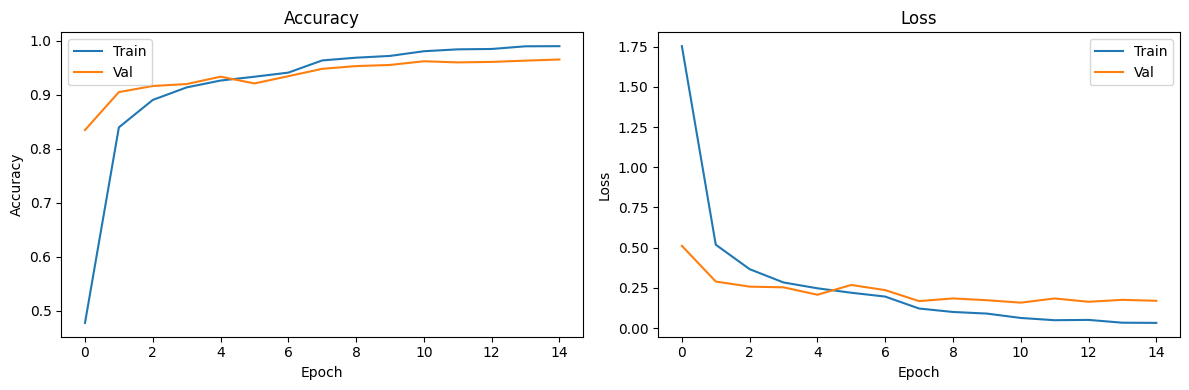

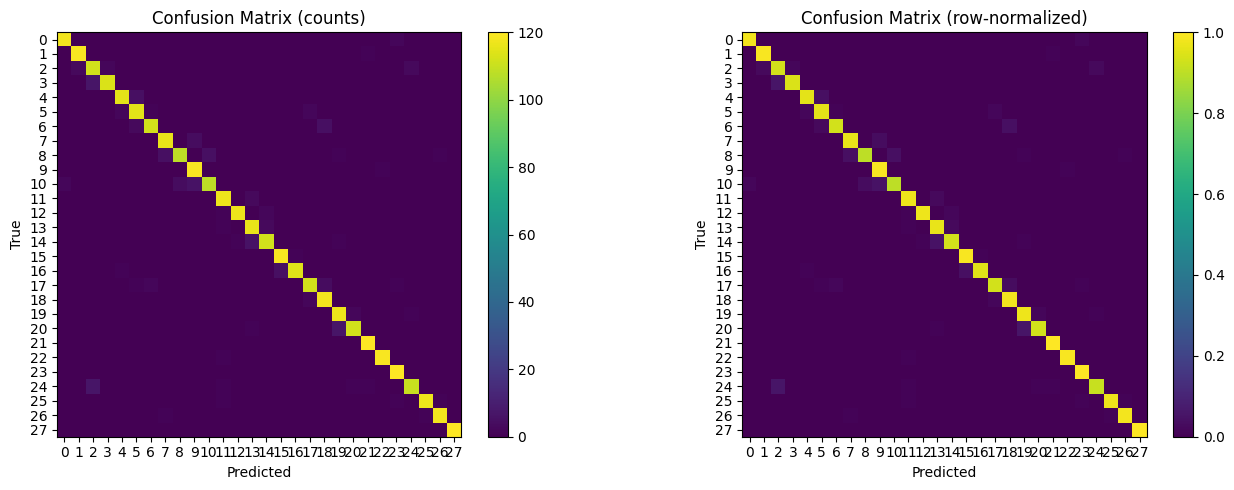

Classification Report:
               precision    recall  f1-score   support

           0     0.9833    0.9833    0.9833       120
           1     0.9754    0.9917    0.9835       120
           2     0.8889    0.9333    0.9106       120
           3     0.9826    0.9417    0.9617       120
           4     0.9746    0.9583    0.9664       120
           5     0.9274    0.9583    0.9426       120
           6     0.9739    0.9333    0.9532       120
           7     0.9508    0.9667    0.9587       120
           8     0.9643    0.9000    0.9310       120
           9     0.9225    0.9917    0.9558       120
          10     0.9558    0.9000    0.9270       120
          11     0.9590    0.9750    0.9669       120
          12     0.9915    0.9750    0.9832       120
          13     0.9206    0.9667    0.9431       120
          14     0.9573    0.9333    0.9451       120
          15     0.9597    0.9917    0.9754       120
          16     0.9913    0.9500    0.9702       120
   

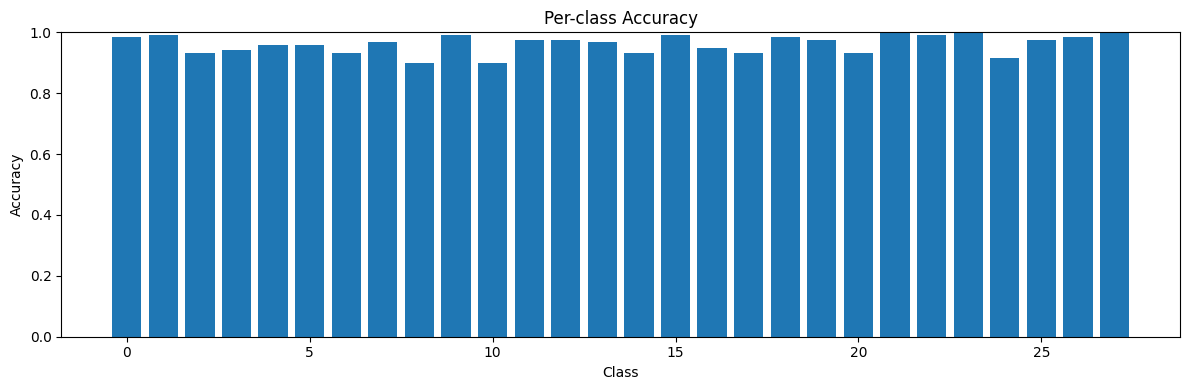


Top 10 most-confused pairs (count, true→pred):
   7  24 → 2
   7  20 → 19
   7  3 → 2
   6  14 → 13
   6  10 → 9
   5  16 → 15
   5  8 → 10
   5  8 → 7
   5  6 → 18
   5  4 → 5


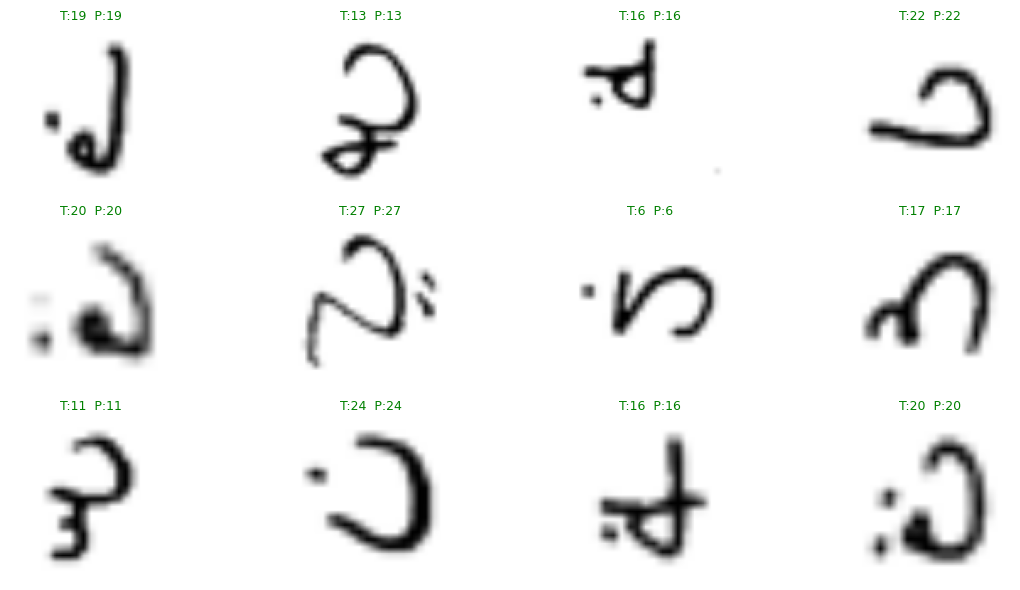


✅ Saved figures: viz_training_curves.png, viz_confusion_matrices.png, viz_per_class_accuracy.png, viz_sample_predictions.png
✅ PDF bundle: report_best_model_visuals.pdf


In [ ]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.backends.backend_pdf import PdfPages

# ---------- 0) Helper: safe class names ----------
class_names = [str(i) for i in range(NUM_CLASSES)]   # replace with Arabic letter names if you have them

# ---------- 1) Training curves from `history` ----------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history.get('accuracy', []), label='Train')
plt.plot(history.history.get('val_accuracy', []), label='Val')
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history.get('loss', []), label='Train')
plt.plot(history.history.get('val_loss', []), label='Val')
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout()
plt.savefig("viz_training_curves.png", dpi=200)
plt.show()

# ---------- 2) Predictions on test_ds ----------
y_true, y_pred = [], []
for xb, yb in test_ds:
    probs = best_model.predict(xb, verbose=0)
    y_pred.append(np.argmax(probs, axis=1))
    y_true.append(yb.numpy())
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# ---------- 3) Confusion matrix (counts + normalized) ----------
cm = confusion_matrix(y_true, y_pred, labels=np.arange(NUM_CLASSES))
cm_norm = cm.astype(np.float64) / (cm.sum(axis=1, keepdims=True) + 1e-9)

fig, axes = plt.subplots(1, 2, figsize=(14,5))
im0 = axes[0].imshow(cm, interpolation='nearest')
axes[0].set_title("Confusion Matrix (counts)"); axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(cm_norm, vmin=0, vmax=1, interpolation='nearest')
axes[1].set_title("Confusion Matrix (row-normalized)"); axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

for ax in axes:
    ax.set_xticks(range(NUM_CLASSES))
    ax.set_yticks(range(NUM_CLASSES))
    # If ticks get cluttered, comment out the lines above and use fewer ticks.

plt.tight_layout()
plt.savefig("viz_confusion_matrices.png", dpi=200)
plt.show()

# ---------- 4) Classification report (text) ----------
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("Classification Report:\n", report)

# ---------- 5) Per-class accuracy bar chart ----------
per_class_acc = np.diag(cm) / (cm.sum(axis=1) + 1e-9)
plt.figure(figsize=(12,4))
plt.bar(np.arange(NUM_CLASSES), per_class_acc)
plt.ylim(0, 1.0)
plt.xlabel("Class"); plt.ylabel("Accuracy")
plt.title("Per-class Accuracy")
plt.tight_layout()
plt.savefig("viz_per_class_accuracy.png", dpi=200)
plt.show()

# ---------- 6) Top-k most confused class pairs ----------
# Off-diagonal largest entries
cm_off = cm.copy()
np.fill_diagonal(cm_off, 0)
pairs = []
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if i != j and cm_off[i, j] > 0:
            pairs.append((cm_off[i, j], i, j))
pairs.sort(reverse=True)
print("\nTop 10 most-confused pairs (count, true→pred):")
for c, i, j in pairs[:10]:
    print(f"{c:4d}  {class_names[i]} → {class_names[j]}")

# ---------- 7) Sample predictions grid ----------
n_show = 12
idxs = np.random.choice(len(yte), size=n_show, replace=False)
plt.figure(figsize=(12,6))
for k, i in enumerate(idxs):
    ax = plt.subplot(3, 4, k+1)
    img = Xte_ready[i]
    pred = np.argmax(best_model.predict(img[None,...], verbose=0))
    true = int(yte[i])
    ax.imshow(img); ax.axis("off")
    color = "green" if pred == true else "red"
    ax.set_title(f"T:{class_names[true]}  P:{class_names[pred]}", color=color, fontsize=9)
plt.tight_layout()
plt.savefig("viz_sample_predictions.png", dpi=200)
plt.show()

# ---------- 8) Save everything to a single PDF bundle ----------
with PdfPages("report_best_model_visuals.pdf") as pdf:
    # training curves
    img = plt.imread("viz_training_curves.png"); plt.figure(figsize=(8,4)); plt.imshow(img); plt.axis('off'); pdf.savefig(); plt.close()
    # confusion matrices
    img = plt.imread("viz_confusion_matrices.png"); plt.figure(figsize=(8,4)); plt.imshow(img); plt.axis('off'); pdf.savefig(); plt.close()
    # per-class accuracy
    img = plt.imread("viz_per_class_accuracy.png"); plt.figure(figsize=(8,4)); plt.imshow(img); plt.axis('off'); pdf.savefig(); plt.close()
    # sample predictions
    img = plt.imread("viz_sample_predictions.png"); plt.figure(figsize=(8,4)); plt.imshow(img); plt.axis('off'); pdf.savefig(); plt.close()

print("\n✅ Saved figures: viz_training_curves.png, viz_confusion_matrices.png, viz_per_class_accuracy.png, viz_sample_predictions.png")
print("✅ PDF bundle: report_best_model_visuals.pdf")


In [ ]:
# ==== Model Summary ====
print("\nBest Model Summary:")
best_model.summary(line_length=120, expand_nested=True)

# ==== Final Training & Validation Accuracy ====
final_train_acc = history.history['accuracy'][-1]
final_val_acc   = history.history['val_accuracy'][-1]

print(f"\n✅ Final Results:")
print(f"   Training Accuracy:     {final_train_acc:.4f}")
print(f"   Validation Accuracy:   {final_val_acc:.4f}")



Best Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ mobilenetv2_0.50_96 (Functional)                    │ (None, 3, 3, 1280)                     │               706,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│    └ input_layer_2 (InputLayer)                     │ (None, 96, 96, 3)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│    └ Conv1 (Conv2D)                                 │ (None, 48, 48, 16)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│    └ bn_Conv1 (BatchNormalization)                  │ (None, 48, 48, 16)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│    └ Conv1_relu (ReLU)                              │ (None, 48, 48, 16)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│    └ expanded_conv_depthwise (DepthwiseConv2D)      │ (None, 48, 48, 16)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│    └ expanded_conv_depthwise_BN                     │ (None, 48, 48, 16)                     │                   
│ (BatchNormalization)                                │                                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│    └ expanded_conv_depthwise_relu (ReLU)            │ (None, 48, 48, 16)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│    └ expanded_conv_project (Conv2D)                 │ (None, 48, 48, 8)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│    └ expanded_conv_project_BN (BatchNormalization)  │ (None, 48, 48, 8)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│    └ block_1_expand (Conv2D)                        │ (None, 48, 48, 48)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│    └ block_1_expand_BN (BatchNormalization)         │ (None, 48, 48, 48)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│    └ block_1_expand_relu (ReLU)                     │ (None, 48, 48, 48)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│    └ block_1_pad (ZeroPadding2D)                    │ (None, 49, 49, 48)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│    └ block_1_depthwise (DepthwiseConv2D)            │ (None, 24, 24, 48)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│    └ block_1_depthwise_BN (BatchNormalization)      │ 

 Total params: 1,768,518 (6.75 MB)

 Trainable params: 489,244 (1.87 MB)

 Non-trainable params: 300,784 (1.15 MB)

 Optimizer params: 978,490 (3.73 MB)


✅ Final Results:
   Training Accuracy:     0.9902
   Validation Accuracy:   0.9655


In [ ]:
loss, test_acc = best_model.evaluate(test_ds, verbose=1)
print(f"   Test Accuracy:         {test_acc:.4f}")


53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 0.9615 - loss: 0.1775
   Test Accuracy:         0.9622


# 📌 Comment on Best Rebuilt MobileNetV2 (Keras Tuner)

The best rebuilt MobileNetV2 model tuned with Keras Tuner achieved 96.22% accuracy, confirming the effectiveness of transfer learning for Arabic handwritten character recognition. Although its accuracy is slightly lower than the CNN models, MobileNetV2 remains highly efficient due to its lightweight design and reduced computational cost. The training and validation curves show stable performance without major overfitting, making this model a strong candidate for real-time or resource-constrained applications.

# Prediction and visualization

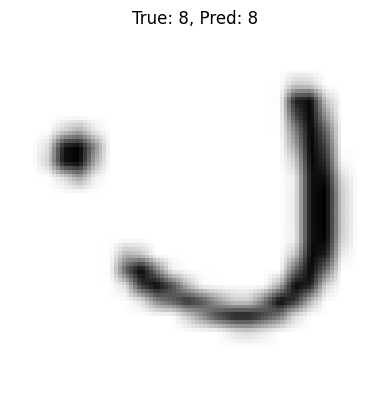

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Pick a random test sample
idx = np.random.randint(0, len(Xte_ready))
img = Xte_ready[idx]
true_label = int(yte[idx])

# Predict
pred_probs = model.predict(img[None, ...], verbose=0)
pred_class = np.argmax(pred_probs)

# Show result
plt.imshow(img)
plt.axis("off")
plt.title(f"True: {true_label}, Pred: {pred_class}")
plt.show()


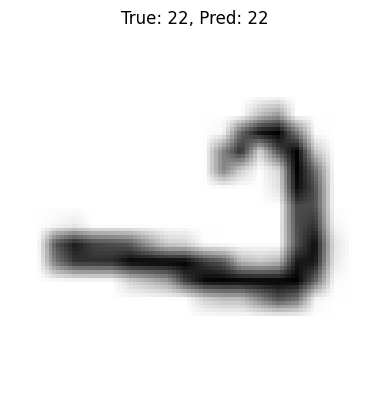

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Pick a random test sample
idx = np.random.randint(0, len(Xte_ready))
img = Xte_ready[idx]
true_label = int(yte[idx])

# Predict
pred_probs = model.predict(img[None, ...], verbose=0)
pred_class = np.argmax(pred_probs)

# Show result
plt.imshow(img)
plt.axis("off")
plt.title(f"True: {true_label}, Pred: {pred_class}")
plt.show()


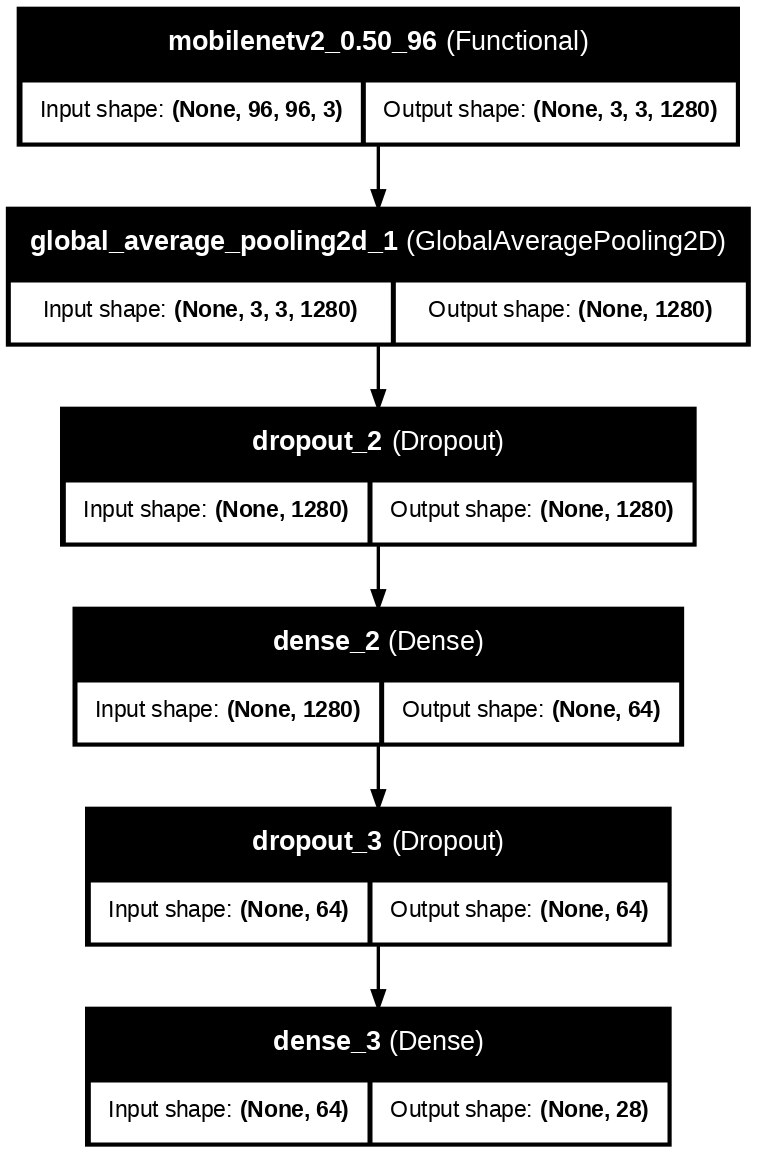

In [ ]:
from tensorflow.keras.utils import plot_model

# Creates PNG diagram of the model
plot_model(
    best_model,
    to_file="best_mobilenetv2_arch.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False,   # keep MobileNetV2 collapsed
    dpi=120
)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import tensorflow as tf

# Get predictions on validation/test set
y_true, y_pred, y_prob = [], [], []
for xb, yb in test_ds:
    p = best_model.predict(xb, verbose=0)
    y_prob.append(p)
    y_true.append(yb.numpy())
    y_pred.append(np.argmax(p, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_prob = np.concatenate(y_prob)

# Macro metrics (final values)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")

# AUC requires one-hot labels
y_true_oh = tf.keras.utils.to_categorical(y_true, num_classes=NUM_CLASSES)
auc = roc_auc_score(y_true_oh, y_prob, average="macro", multi_class="ovr")

print(f"Final Precision: {precision:.4f}")
print(f"Final Recall:    {recall:.4f}")
print(f"Final F1:        {f1:.4f}")
print(f"Final AUC:       {auc:.4f}")


Final Precision: 0.9656
Final Recall:    0.9652
Final F1:        0.9651
Final AUC:       0.9993
